In [70]:
import seaborn as sns
import pandas as pd
from collections import namedtuple
from pprint import pprint
import sys
from copy import deepcopy
import pickle
import pyccl as ccl
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KernelDensity
from scipy.stats import iqr
from fisher2 import Fisher, FullPlot, marginalize, plot_contours
import numpy as np
from itertools import permutations
%pylab inline
from scipy.optimize import curve_fit

from wigner_transform import *

from hankel_transform import *


Populating the interactive namespace from numpy and matplotlib


/Users/zhangtianqing/mambaforge/envs/yoda/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['f', 'ylim']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
!which python

/Users/zhangtianqing/mambaforge/envs/yoda/bin/python


In [3]:
cosmo_linear = ccl.Cosmology(Omega_c = 0.2666,
                     Omega_b = 0.049,
                     h = 0.6727,
                     sigma8 = 0.831,
                     n_s = 0.9645,
                     transfer_function = 'eisenstein_hu',
                     matter_power_spectrum = 'linear'
                     )

In [4]:
cosmo_nonlinear = ccl.Cosmology(Omega_c = 0.2666,
                     Omega_b = 0.049,
                     h = 0.6727,
                     sigma8 = 0.831,
                     n_s = 0.9645,
                     transfer_function = 'eisenstein_hu')

In [5]:
nonlinear = Fisher(cosmo_nonlinear)

In [7]:
nonlinear._makeSourcePZ()
nonlinear.getElls()
_ = nonlinear.makeCells()
nonlinear.buildCovMatrix()

Making Source Photo-z


/Users/zhangtianqing/mambaforge/envs/yoda/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator KernelDensity from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


Getting Ells
making C_ells
Getting covariance matrix


In [8]:
with open('nonlinear_deriv.pkl', 'rb') as output:
    nonlinear_derivs = pickle.load(output)

In [8]:
#nonlinear.derivs_sig = nonlinear_derivs
nonlinear.getDerivs(cosmo = True)

nonlinear.getFisher(nonlinear.cosmo)
nonlinear.has_run = True
print('Done')

Getting derivatives
omega_m
sigma_8
n_s
w_0
w_a
omega_b
h
A0
beta
etal
etah
Building fisher matrix
Done


In [32]:
nonlinear.process(cosmo = True)

Making Source Photo-z


/Users/zhangtianqing/mambaforge/envs/yoda/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator KernelDensity from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


Getting Ells
making C_ells
Getting covariance matrix
Getting derivatives
omega_m
sigma_8
n_s
w_0
w_a
omega_b
h
A0
beta
etal
etah
Building fisher matrix
Done


In [9]:
with open('nonlinear_deriv.pkl', 'wb') as output:
    pickle.dump(nonlinear.derivs_sig, output, pickle.HIGHEST_PROTOCOL)

In [6]:
linear = Fisher(cosmo_linear)

In [7]:
linear.process(cosmo = True)

Making Source Photo-z
Getting Ells
making C_ells
Getting covariance matrix
Getting derivatives
Building fisher matrix
Done


In [10]:
#Setup Wigner Transformation

theta_min=0.0001
theta_deg = np.logspace(np.log10(theta_min),np.log10(180.0), 10000)
#theta_deg = np.arange(0.01, 180.0, 0.01)
theta_rad = theta_deg/180.0*np.pi

# j_nu=0
# rmin=0.01/180.0*np.pi
# rmax=np.pi

# ellmin= 2
# ellmax= 3072

# n_zeros=5000

# HT_inv=hankel_transform(rmin=ellmin,rmax=ellmax,kmin=rmin,kmax=rmax,j_nu=[j_nu],n_zeros=n_zeros)

j_nu=0
rmin=0.0001/180.0*np.pi
rmax=np.pi

ellmin=2
ellmax=3072
ell=np.arange(ellmin,ellmax)

n_zeros=50000

# HT_inv=hankel_transform(rmin=ellmin,rmax=ellmax,kmin=rmin,kmax=rmax,j_nu=[j_nu],n_zeros=n_zeros)
WT=wigner_transform(theta=theta_rad,l=ell,s1_s2=[(0,0)])

In [11]:
def data2xip(lst, model, polys):
    bias_term = []
    for i in range(5):
        for j in range(i,5):
            z1z2 = lst[i]+lst[j]
            this_params = []
            for p in range(len(polys)):
                this_poly = polys[p][0]*z1z2 + polys[p][1]
                this_params.append(this_poly)
            #print(amp,level)
            bias_term.append(model(theta_deg*60,*this_params))
    return bias_term

In [12]:
def bin_mat(r=[],mat=[],r_bins=[]):#works for cov and skewness
    bin_center=np.sqrt(r_bins[1:]*r_bins[:-1])
    n_bins=len(bin_center)
    ndim=len(mat.shape)
    mat_int=np.zeros([n_bins]*ndim,dtype='float64')
    norm_int=np.zeros([n_bins]*ndim,dtype='float64')
    bin_idx=np.digitize(r,r_bins)-1
    r2=np.sort(np.unique(np.append(r,r_bins))) #this takes care of problems around bin edges
    dr=np.gradient(r2)
    r2_idx=[i for i in np.arange(len(r2)) if r2[i] in r]
    dr=dr[r2_idx]
    r_dr=r*dr

    ls=['i','j','k','l']
    s1=ls[0]
    s2=ls[0]
    r_dr_m=r_dr
    for i in np.arange(ndim-1):
        s1=s2+','+ls[i+1]
        s2+=ls[i+1]
        r_dr_m=np.einsum(s1+'->'+s2,r_dr_m,r_dr)#works ok for 2-d case

    mat_r_dr=mat*r_dr_m
    for indxs in itertools.product(np.arange(min(bin_idx),n_bins),repeat=ndim):
        x={}#np.zeros_like(mat_r_dr,dtype='bool')
        norm_ijk=1
        mat_t=[]
        for nd in np.arange(ndim):
            slc = [slice(None)] * (ndim)
            #x[nd]=bin_idx==indxs[nd]
            slc[nd]=bin_idx==indxs[nd]
            if nd==0:
                mat_t=mat_r_dr[slc]
            else:
                mat_t=mat_t[slc]
            norm_ijk*=np.sum(r_dr[slc[nd]])
        if norm_ijk==0:
            continue
        mat_int[indxs]=np.sum(mat_t)/norm_ijk
        norm_int[indxs]=norm_ijk
    return bin_center,mat_int

In [13]:
#From delta C_ell to parameter shift

def Cell2parambias(bias_fisher_cl, fisher, param_order  ):
    cl_unbiased = np.array(fisher.ccl_cls['C_ell']).reshape(15, 15)
    cl_biased = []
    count = 0
    for i in range(5):
        for j in range(i,5):
            this_biased = cl_unbiased[count]+bias_fisher_cl[count]
            cl_biased.append(this_biased)
            count+=1
    cl_biased = np.array(cl_biased)
    cl_unbiased = cl_unbiased.T
    cl_biased = cl_biased.T
    
    
    
    #diff_cl = np.column_stack(cl_biased - cl_unbiased)
    diff_cl = cl_biased - cl_unbiased
    bias_vec = []
    for i, param in enumerate(param_order):
        bias_vec.append(sum(diff_cl[idx].dot(
                np.array(fisher.invcov_list[idx]).dot(fisher.derivs_sig[param][idx])
                ) for idx in range(len(fisher.ell))))
    bias_vec = np.array(bias_vec)
    para_bias = np.linalg.inv(fisher.fisher).dot(bias_vec) 
    para_bias = {param_order[i]: para_bias[i] for i in range(11)}
    
    return para_bias
    
    

In [14]:
#Models to express the delta xi_+ from PSF
def model1(x,amp,scale):
    return amp*np.exp(-scale*x)
    

def model2(x, amp):
    return np.maximum(amp*np.exp(-0.15*x),amp*np.exp(-0.15*9))




def model4(x, amp, scale, level):
    return (amp*np.exp(-scale*x))+level



def model5(x,amp,  level):
    return amp * np.power(x, -0.0085) * ((-np.arctan(x - 2.6 ))/np.pi + 1/2 )+level*np.power(x, -0.1)


def model6(x, amp, b):
    return amp * np.power(x, -b)




In [15]:
#Calculate the C_ell bias from xi+, on ells that we are interested in. 
def xip2cl(theta_rad, bias_term, ell_bound):
    bin_cl_bias = []
    for i in range(15):
        #print(i)
        #bias_ell, this_bias = HT_inv.projected_correlation(k_pk=theta_real,pk=bias_term[i],j_nu=0)
        bias_ell, this_bias = WT.inv_projected_correlation(theta_xi=theta_rad,xi=bias_term[i],s1_s2=(0,0))
        #print(bias_ell.shape, this_bias.shape)
        _, ave_cell = bin_mat(r=bias_ell,mat=this_bias,r_bins=np.array(ell_bound))
        bin_cl_bias.append(ave_cell)
    return bin_cl_bias

In [16]:
def plot_all_param(para_bias,Fisher,filename = None):
    
    bias_ell = Fisher.ell
    vals = Fisher.vals
    fisher = Fisher.fisher
    cov = np.linalg.inv(fisher)

    
    if filename!=None:
        with open(filename, 'wb') as output:
            pickle.dump([bias_ell,vals,fisher, cov , param_order, para_bias], output, pickle.HIGHEST_PROTOCOL)
        
    
    
    
    
    colors = ['black', 'green']

    xlim_range = [[0.3,0.4],[-2.5,-0.75]]
    ylim_range = [[0.6,0.85],[-1,4.0]]
    plt.rc('axes', titlesize=14)     # fontsize of the axes title
    plt.rc('axes', labelsize=14)    # fontsize of the x and y labels


    fig = plt.figure(figsize = (21,21))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.0)


    # for count, params in enumerate([['omega_m', 'sigma_8'],
    #                ['w_0', 'w_a']]):

    for row in range(7):
        for col in range(row+1,7):
            params = [param_order[row], param_order[col]]

            labels = ['unbiased', 'biased']
            biases = [para_bias[params[0]], para_bias[params[1]]]
            fid = (vals[params[0]], vals[params[1]])
            es = []

            index1 = param_order.index(params[0])
            index2 = param_order.index(params[1])

            my_xlim = [fid[0] - 3*np.sqrt(cov[index1][index1]) , fid[0] + 3*np.sqrt(cov[index1][index1])]
            my_ylim = [fid[1] - 3*np.sqrt(cov[index2][index2]) , fid[1] + 3*np.sqrt(cov[index2][index2])]


            for i, matrix in enumerate([fisher, fisher]):
                if i==1:
                    #print('changing fid')
                    fid = (fid[0]+biases[0], fid[1]+biases[1])

                e, (xlim, ylim) = plot_contours(marginalize(matrix, param_order.index(params[0]), param_order.index(params[1])),
                                  sigmas=1,
                                  fid=fid)
                e.set_edgecolor(colors[i])
                e.set_facecolor(colors[i])
                e.set_label(labels[i])
                e.set_fill(False)
                e.set_alpha(0.3)
                es.append(e)
            ax = plt.subplot(7,7,7*col+row+1)
            subplot_number = 7*col+row+1

            for i, e in enumerate(es):
                ax.add_artist(e)

            ax.tick_params(
                axis='x',          # changes apply to the x-axis
                direction = 'in',
                which='both',      # both major and minor ticks are affected
                bottom=True,      # ticks along the bottom edge are off
                top=True,         # ticks along the top edge are off
                labelbottom=False)

            ax.tick_params(
                axis='y',          # changes apply to the x-axis
                direction = 'in',
                which='both',      # both major and minor ticks are affected
                left=True,      # ticks along the bottom edge are off
                right=True,         # ticks along the top edge are off
                labelleft=False)

            if subplot_number in list(range(43,49)):
                plt.xlabel(param_labels[param_order.index(params[0])])
                ax.tick_params(
                    axis='x',          # changes apply to the x-axis
                    direction = 'in',
                    which='both',      # both major and minor ticks are affected
                    bottom=True,      # ticks along the bottom edge are off
                    top=True,         # ticks along the top edge are off
                    labelbottom=True)
            if (subplot_number-1)%7==0:
                plt.ylabel(param_labels[param_order.index(params[1])])
                #plt.ticklabel_format(axis='y',style='scientific',scilimits=(0,3))
                ax.tick_params(
                    axis='y',          # changes apply to the x-axis
                    direction = 'in',
                    which='both',      # both major and minor ticks are affected
                    left=True,      # ticks along the bottom edge are off
                    right=True,         # ticks along the top edge are off
                    labelleft=True)
            #plt.title(str(subplot_number))
            #plt.xlim([-1.1, -0.9])
            plt.xlim(my_xlim)
            plt.ylim(my_ylim)
            #plt.legend(handles=es)


    plt.show()
    
    fid = []
    sig = []
    para_shift = []
    for i in range(7):
        param = param_order[i]
        fid.append(vals[param])
        index = param_order.index(param)
        sig.append(np.sqrt(cov[index][index]))
        para_shift.append(para_bias[param])
    print()
            #plt.figure()

In [83]:
def printoutshift(para_bias,Fisher):
    
    bias_ell = Fisher.ell
    vals = Fisher.vals
    fisher = Fisher.fisher
    cov = np.linalg.inv(fisher)
    parameters_wl = ['omega_m', 'sigma_8','w_0', 'w_a']
    fid = []
    sig = []
    para_shift = []
    for i in range(7):
        param = param_order[i]
        fid.append(vals[param])
        index = param_order.index(param)
        sig.append(np.sqrt(cov[index][index]))
        para_shift.append(para_bias[param])
    print ("{:<15} {:<15} {:<15} {:<15}".format('Parameter','Fiducial Value','Sigma','Shift / Sigma'))
    shift2sigma = []
    for i in range(7):

        print ("{:<15} {:<15} {:<15} {:<15}".format(param_order[i], fid[i], round(sig[i],4), round(para_shift[i]/sig[i],4)))
        if param_order[i] in parameters_wl:
            shift2sigma.append(para_shift[i]/sig[i])
    print(shift2sigma) 
    print("average shift: {}".format(np.mean(np.abs(shift2sigma))))
           

In [18]:
with open('data/bpd_tomographic/raw_results.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    raw_results = pickle.load(f)[0]
with open('data/bpd_tomographic/obs_results.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    obs_results = pickle.load(f)[0]
with open('data/bpd_tomographic/diff_results.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    diff_results = pickle.load(f)[0]

In [19]:
n_tomo = 3
tomo_division = [0.8,1.5]
zmid = [0.50, 1.06, 1.85]

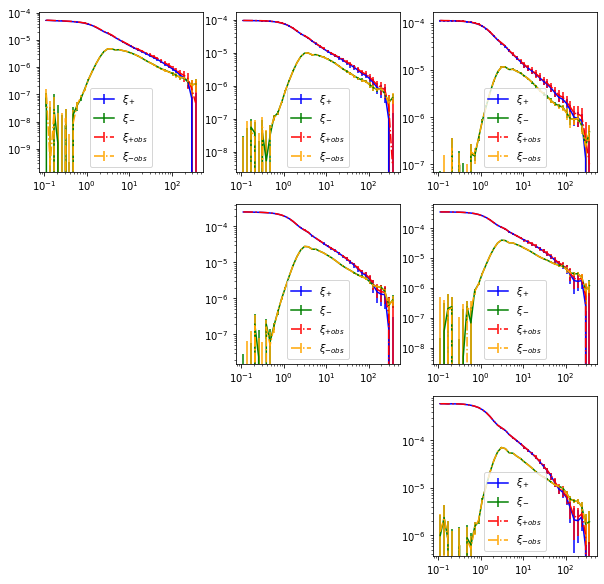

In [20]:
plt.figure(figsize = (10,10))

for i in range(n_tomo):
    for j in range(i,n_tomo):
        #print(i,j)
        plt.subplot(n_tomo,n_tomo,n_tomo*i+j+1)
        
        r = raw_results['r']
        xip_raw = raw_results['xip_raw_'+str(i)+str(j)]
        xim_raw = raw_results['xim_raw_'+str(i)+str(j)]
        
        xip_raw_sig = raw_results['sigxip_raw_'+str(i)+str(j)]
        xim_raw_sig = raw_results['sigxim_raw_'+str(i)+str(j)]
        
        xip_obs = obs_results['xip_obs_'+str(i)+str(j)]
        xim_obs = obs_results['xim_obs_'+str(i)+str(j)]
        
        xip_obs_sig = obs_results['sigxip_obs_'+str(i)+str(j)]
        xim_obs_sig = obs_results['sigxim_obs_'+str(i)+str(j)]
        
        plt.errorbar(r,xip_raw,xip_raw_sig, color = 'blue',label = r'$\xi_+$')
        plt.errorbar(r,xim_raw,xim_raw_sig, color = 'green',label = r'$\xi_-$')

        plt.errorbar(r,xip_obs,xip_obs_sig, fmt= '-.', color = 'red',label = r'$\xi_{+ obs}$')
        plt.errorbar(r,xim_obs,xim_obs_sig, fmt= '-.', color = 'orange',label = r'$\xi_{- obs}$')


        plt.xscale('log')
        plt.yscale('log')
        plt.legend()
        

In [21]:

def expconst(x,amp, scale,level):
    return amp*np.exp(-scale*x)+level


def powerlaw(x,amp, b):
    return amp * np.power(x, -b)


def explaw(x,amp,scale):
    return amp*np.exp(-scale*x)

def twoexp(x, amp1, scale1, amp2, scale2):
    return amp1*np.exp(-scale1*x)+amp2*np.exp(-scale2*x)


/var/folders/cw/jqrw84tx2jb5fj92jz93n91r0000gn/T/ipykernel_33065/1535175772.py:2: RuntimeWarning: overflow encountered in exp
  return amp*np.exp(-scale*x)+level
/var/folders/cw/jqrw84tx2jb5fj92jz93n91r0000gn/T/ipykernel_33065/1535175772.py:10: RuntimeWarning: overflow encountered in exp
  return amp*np.exp(-scale*x)


(-0.05500000000000001,
 0.05500000000000001,
 -0.05500000000000001,
 0.05500000000000001)

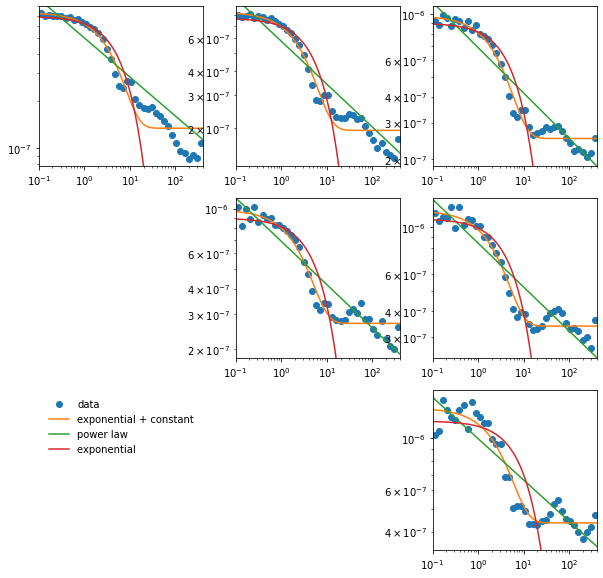

In [22]:
plt.figure(figsize = (10,10))
epsilon = 0.00001


for i in range(n_tomo):
    for j in range(i,n_tomo):
        
        plt.subplot(n_tomo,n_tomo,n_tomo*i+j+1)
        r = raw_results['r']
        xip_raw = raw_results['xip_raw_'+str(i)+str(j)]
        xim_raw = raw_results['xim_raw_'+str(i)+str(j)]

        xip_obs = obs_results['xip_obs_'+str(i)+str(j)]
        xim_obs = obs_results['xim_obs_'+str(i)+str(j)]


        delta_xip = np.abs(xip_raw - xip_obs)
        delta_xim = np.abs(xim_raw - xim_obs)
        plt.plot(r, delta_xip, 'o',  label = r'data')
        
        
        x_fit = np.arange(0.1,400,0.1)
        
        
        popt1, _ = curve_fit(expconst,r,delta_xip)
        y_fit1 = expconst(x_fit,popt1[0], popt1[1],popt1[2])
        plt.plot(x_fit,y_fit1, label = r'exponential + constant')
        

        
        popt2, _ = curve_fit(powerlaw,r,delta_xip)
        y_fit2 = powerlaw(x_fit,popt2[0], popt2[1])
        plt.plot(x_fit,y_fit2, label = r'power law')

        popt3, _ = curve_fit(explaw,r,delta_xip)
        y_fit3 = explaw(x_fit,popt3[0], popt3[1])
        plt.plot(x_fit,y_fit3, label = r'exponential ')

        
        plt.ylim(0.9*np.min(delta_xip),1.1*np.max(delta_xip))
        plt.xlim([0.1,400])
        plt.xscale('log')
        plt.yscale('log')

plt.subplot(3,3,7)
plt.plot([],[],'o',label = r'data')
plt.plot([0],[0],label = r'exponential + constant')
plt.plot([0],[0],label = r'power law')
plt.plot([0],[0],label = r'exponential ')


plt.legend(frameon = False)     
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
ax.axis('off')
        
        
#plt.savefig('figure/delta_xip_fit.png',dpi = 100)

0 0
0 1
0 2
1 1
1 2
2 2


/var/folders/cw/jqrw84tx2jb5fj92jz93n91r0000gn/T/ipykernel_33065/1535175772.py:13: RuntimeWarning: overflow encountered in exp
  return amp1*np.exp(-scale1*x)+amp2*np.exp(-scale2*x)
/var/folders/cw/jqrw84tx2jb5fj92jz93n91r0000gn/T/ipykernel_33065/1535175772.py:13: RuntimeWarning: overflow encountered in exp
  return amp1*np.exp(-scale1*x)+amp2*np.exp(-scale2*x)
/var/folders/cw/jqrw84tx2jb5fj92jz93n91r0000gn/T/ipykernel_33065/1535175772.py:13: RuntimeWarning: overflow encountered in exp
  return amp1*np.exp(-scale1*x)+amp2*np.exp(-scale2*x)
/var/folders/cw/jqrw84tx2jb5fj92jz93n91r0000gn/T/ipykernel_33065/1535175772.py:13: RuntimeWarning: overflow encountered in exp
  return amp1*np.exp(-scale1*x)+amp2*np.exp(-scale2*x)
/var/folders/cw/jqrw84tx2jb5fj92jz93n91r0000gn/T/ipykernel_33065/1535175772.py:13: RuntimeWarning: overflow encountered in exp
  return amp1*np.exp(-scale1*x)+amp2*np.exp(-scale2*x)
/var/folders/cw/jqrw84tx2jb5fj92jz93n91r0000gn/T/ipykernel_33065/1535175772.py:13: Runtime

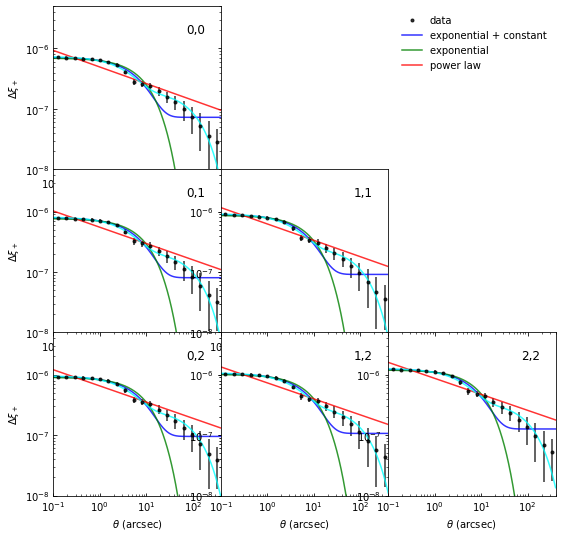

In [23]:
fig = plt.figure(figsize = (9,9))
epsilon = 0.00001
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.0)

ylim = [[8e-8,1e-6],[1.2e-7,1.1e-6 ],[1.8e-7,1.8e-6]]


z1z2 = []


expconst_params = []
power_params = []
exp_params = []
two_exp_params = []

for i in range(n_tomo):
    for j in range(i,n_tomo):
        
        print(i,j)
        ax = plt.subplot(n_tomo,n_tomo,i+n_tomo*j+1)
        r = diff_results['r']


        delta_xip = diff_results['xip_diff_'+str(i)+str(j)]
        delta_xim = diff_results['xip_diff_'+str(i)+str(j)]
        
        cov_xip = diff_results['cov_diff_'+str(i)+str(j)][:20,:20] 
        
        errorbar_xip = np.sqrt(np.diag(cov_xip))
        #errorbar_xim = np.diag(diff_results['cov_diff_'+str(i)+str(j)][20:,20:])
        
        z1z2.append(zmid[i]+zmid[j])
        
        
        #print(delta_xip)

        
        plt.errorbar(r, delta_xip,errorbar_xip, fmt= '.',  label = r'data', color = 'black', alpha = 0.8)
        
        
        x_fit = np.arange(0.1,400,0.1)
        
        
        popt1, _ = curve_fit(expconst,r,delta_xip, sigma = errorbar_xip)
        y_fit1 = expconst(x_fit,popt1[0], popt1[1],popt1[2])
        plt.plot(x_fit,y_fit1, label = r'exponential + constant', color = 'blue', alpha = 0.8)
        
        expconst_params.append(popt1)
        #print(popt1, pcov1)

        popt3, _ = curve_fit(explaw,r,delta_xip,sigma = errorbar_xip, bounds = [[0.9*delta_xip[0],-999 ], [1.1*delta_xip[0], 999]] )
        #print(popt3)
        y_fit3 = explaw(x_fit,popt3[0], popt3[1])
        plt.plot(x_fit,y_fit3, label = r'exponential ', color = 'green', alpha = 0.8)
        exp_params.append(popt3)
        
        popt2, _ = curve_fit(powerlaw,r,delta_xip,sigma = errorbar_xip)
        y_fit2 = powerlaw(x_fit,popt2[0], popt2[1])
        plt.plot(x_fit,y_fit2, label = r'power law', color = 'red', alpha = 0.8)
        power_params.append(popt2)
        
        popt4, _ =  curve_fit(twoexp, r, delta_xip, sigma = errorbar_xip)
        if popt4[2]>popt4[0]:
            popt4 = np.array([popt4[2],popt4[3],popt4[0],popt4[1] ])
        y_fit4 = twoexp(x_fit, *popt4)
        plt.plot(x_fit,y_fit4, label = r'double-exp', color = 'cyan', alpha = 0.8)
        two_exp_params.append(popt4)

        if j==2:
            plt.xlabel(r"$\theta$ (arcsec)")
            ax.tick_params(
                axis='x',          # changes apply to the x-axis
                direction = 'in',
                which='both',      # both major and minor ticks are affected
                bottom=True,      # ticks along the bottom edge are off
                top=True,         # ticks along the top edge are off
                labelbottom=True)
           
        if i==0:
        
            plt.ylabel(r'$\Delta \xi_+$')
            #plt.ticklabel_format(axis='y',style='scientific',scilimits=(0,3))
            ax.tick_params(
                axis='y',          # changes apply to the x-axis
                direction = 'in',
                which='both',      # both major and minor ticks are affected
                left=True,      # ticks along the bottom edge are off
                right=True,         # ticks along the top edge are off
                labelleft=True)

        plt.title(str(i)+','+str(j), y = 0.8, x = 0.85)
        
        plt.xlim([0.1,400])
        plt.ylim([1e-8,5e-6])
        plt.xscale('log')
        plt.yscale('log')
        
        

plt.subplot(3,3,3)
plt.plot([],[],'.',label = r'data', color = 'black', alpha = 0.8)
plt.plot([0],[0],label = r'exponential + constant', color = 'blue', alpha = 0.8)
plt.plot([0],[0],label = r'exponential ', color = 'green', alpha = 0.8)
plt.plot([0],[0],label = r'power law', color = 'red', alpha = 0.8)



plt.legend(frameon = False)     
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
ax.axis('off')



        
exp_params = np.array(exp_params).T
power_params = np.array(power_params).T
expconst_params = np.array(expconst_params).T
two_exp_params = np.array(two_exp_params).T

z1z2 = np.array(z1z2)


In [24]:
with open('../plots2/pickle/xi+fitting.pkl', 'wb') as f:
    pickle.dump([n_tomo,raw_results, ] , f)

ValueError: operands could not be broadcast together with shapes (20,) (40,) 

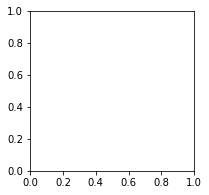

In [49]:
plt.figure(figsize = (10,10))
epsilon = 0.00001


for i in range(n_tomo):
    for j in range(i,n_tomo):
        
        plt.subplot(n_tomo,n_tomo,n_tomo*i+j+1)
        r = raw_results['r']
        xip_raw = raw_results['xip_raw_'+str(i)+str(j)]
        #xim_raw = raw_results['xim_raw_'+str(i)+str(j)]

        xip_obs = obs_results['xip_obs_'+str(i)+str(j)]
        #xim_obs = obs_results['xim_obs_'+str(i)+str(j)]


        delta_xip = diff_results['xip_diff_'+str(i)+str(j)]
        #delta_xim = np.abs(xim_raw - xim_obs)
        plt.plot(r, delta_xip/xip_raw, 'o',  label = r'data')
        
        
        x_fit = r
        
        
        popt1, _ = curve_fit(expconst,r,delta_xip)
        y_fit1 = expconst(x_fit,popt1[0], popt1[1],popt1[2])
        plt.plot(x_fit,y_fit1/xip_raw, label = r'exponential + constant')
        

        
        popt2, _ = curve_fit(powerlaw,r,delta_xip)
        y_fit2 = powerlaw(x_fit,popt2[0], popt2[1])
        plt.plot(x_fit,y_fit2/xip_raw, label = r'power law')

        popt3, _ = curve_fit(explaw,r,delta_xip)
        y_fit3 = explaw(x_fit,popt3[0], popt3[1])
        plt.plot(x_fit,y_fit3/xip_raw, label = r'exponential ')

        
        plt.ylim(0.001,1)
        plt.xlim([0.1,400])
        plt.xscale('log')
        plt.yscale('log')

plt.subplot(3,3,7)
plt.plot([],[],'o',label = r'data')
plt.plot([0],[0],label = r'exponential + constant')
plt.plot([0],[0],label = r'power law')
plt.plot([0],[0],label = r'exponential ')


plt.legend(frameon = False)     
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
ax.axis('off')
        
        
#plt.savefig('figure/delta_xip_fit.png',dpi = 100)

In [25]:



exp_poly1 = np.polyfit(z1z2, exp_params[0], 1)
exp_poly2 = np.polyfit(z1z2, exp_params[1], 1)
exp_polys = [exp_poly1,exp_poly2]


expconst_poly1 = np.polyfit(z1z2, expconst_params[0], 1)
expconst_poly2 = np.polyfit(z1z2, expconst_params[1], 1)
expconst_poly3 = np.polyfit(z1z2, expconst_params[2], 1)
expconst_polys = [expconst_poly1,expconst_poly2,expconst_poly3]





power_poly1 = np.polyfit(z1z2, power_params[0], 1)
power_poly2 = np.polyfit(z1z2, power_params[1], 1)
power_polys = [power_poly1,power_poly2]





twoexp_poly1 = np.polyfit(z1z2, two_exp_params[0], 1)
twoexp_poly2 = np.polyfit(z1z2, two_exp_params[1], 1)
twoexp_poly3 = np.polyfit(z1z2, two_exp_params[2], 1)
twoexp_poly4 = np.polyfit(z1z2, two_exp_params[3], 1)
twoexp_polys = [twoexp_poly1,twoexp_poly2,twoexp_poly3,twoexp_poly4]

    


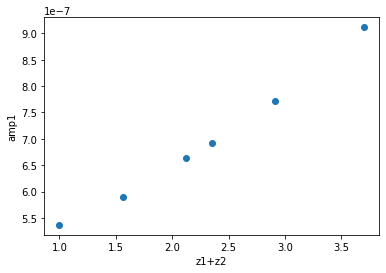

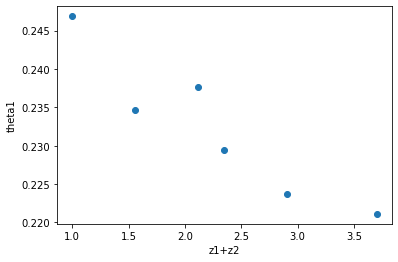

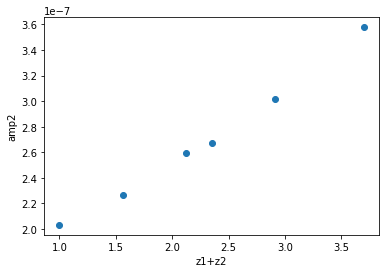

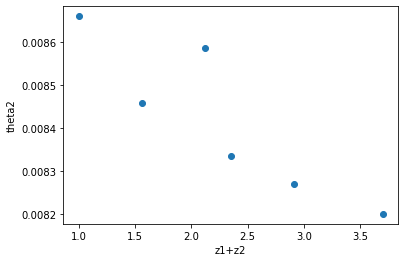

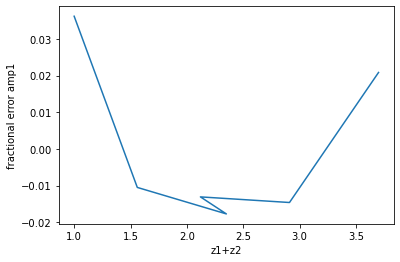

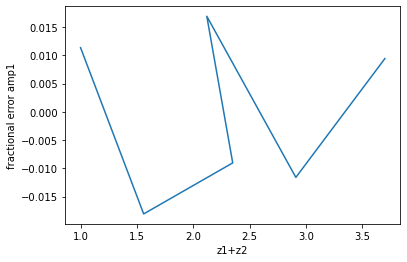

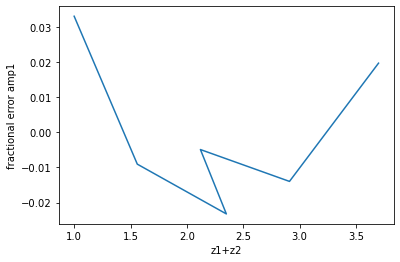

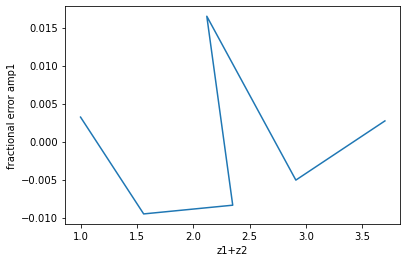

In [26]:

plt.plot(z1z2, two_exp_params[0], 'o')
plt.xlabel('z1+z2')
plt.ylabel('amp1')

plt.show()

plt.plot(z1z2, two_exp_params[1], 'o')
plt.xlabel('z1+z2')
plt.ylabel('theta1')

plt.show()

plt.plot(z1z2, two_exp_params[2], 'o')
plt.xlabel('z1+z2')
plt.ylabel('amp2')

plt.show()

plt.plot(z1z2, two_exp_params[3], 'o')
plt.xlabel('z1+z2')
plt.ylabel('theta2')

plt.show()

relative_residual = (two_exp_params[0] - (twoexp_poly1[0]*z1z2 + twoexp_poly1[1]))/two_exp_params[0]
plt.plot(z1z2,relative_residual )
plt.xlabel('z1+z2')
plt.ylabel('fractional error amp1')
plt.show()

relative_residual = (two_exp_params[1] - (twoexp_poly2[0]*z1z2 + twoexp_poly2[1]))/two_exp_params[1]
plt.plot(z1z2,relative_residual )
plt.xlabel('z1+z2')
plt.ylabel('fractional error amp1')
plt.show()

relative_residual = (two_exp_params[2] - (twoexp_poly3[0]*z1z2 + twoexp_poly3[1]))/two_exp_params[2]
plt.plot(z1z2,relative_residual )
plt.xlabel('z1+z2')
plt.ylabel('fractional error amp1')
plt.show()

relative_residual = (two_exp_params[3] - (twoexp_poly4[0]*z1z2 + twoexp_poly4[1]))/two_exp_params[3]
plt.plot(z1z2,relative_residual )
plt.xlabel('z1+z2')
plt.ylabel('fractional error amp1')
plt.show()

In [27]:
two_exp_params.T

array([[5.36909495e-07, 2.46864412e-01, 2.03161588e-07, 8.66015994e-03],
       [5.89065923e-07, 2.34623026e-01, 2.26393330e-07, 8.45754000e-03],
       [6.92711097e-07, 2.29465316e-01, 2.67376618e-07, 8.33530122e-03],
       [6.64351612e-07, 2.37697788e-01, 2.59175612e-07, 8.58534921e-03],
       [7.71509780e-07, 2.23750606e-01, 3.01379648e-07, 8.26890786e-03],
       [9.11561988e-07, 2.21111450e-01, 3.57787610e-07, 8.20015152e-03]])

In [28]:
two_exp_params[0]/two_exp_params[2]

array([2.64277071, 2.60195795, 2.59076916, 2.56332611, 2.55992661,
       2.54777405])

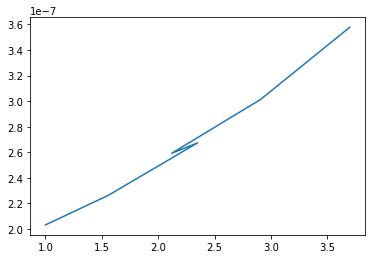

In [29]:
plt.plot(z1z2,two_exp_params[2] )

In [55]:
#Best fit parameters to these models
#model 6
poly1_m6 = [1.86232559e-07, 2.95918792e-07]
poly2_m6 = [-0.02769742,  0.26992384]


# #model 5
poly1_m5 = [-9.71665443e-09,  3.30458077e-07]
poly2_m5 = [1.87129764e-07, 1.19270273e-07]

# #model 4

poly1_m4 = [1.25446537e-07, 4.57800142e-07]
#poly2_m4 = [0.01546336, 0.23153227]
poly2_m4 = [-0.01546336, 0.23153227]

#poly2_m4 = [1.06940873e-07, 2.87882519e-08]


#model 1

poly1_m1 = [1.93352532e-07, 4.83016453e-07]
poly2_m1 = [-0.0166599,   0.13206969]

In [56]:
nonlinear.fisher

array([[ 9.41234506e+06,  7.09085706e+06,  9.31207864e+05,
        -3.38442950e+05, -1.13216914e+05,  7.21420733e+06,
         5.91254688e+05,  2.56659918e+04, -6.78068486e+05,
         3.23900629e+04,  1.86623814e+04],
       [ 7.09085706e+06,  5.51867849e+06,  7.33116287e+05,
        -2.90947180e+05, -9.38750123e+04,  5.40279231e+06,
         4.57832089e+05, -2.43826017e+03, -2.15064364e+05,
        -2.06025359e+04,  1.54077926e+04],
       [ 9.31207864e+05,  7.33116287e+05,  2.26971537e+05,
        -4.94762660e+04, -1.42619216e+04,  5.11310331e+05,
         1.14800135e+05, -1.34788481e+04,  1.28864240e+05,
        -3.20965600e+04,  6.79848126e+02],
       [-3.38442950e+05, -2.90947180e+05, -4.94762660e+04,
         3.05579148e+04,  7.46461079e+03, -2.34275791e+05,
        -2.82299928e+04,  9.17616593e+03, -1.04801915e+05,
         1.96583197e+04, -5.25300651e+02],
       [-1.13216914e+05, -9.38750123e+04, -1.42619216e+04,
         7.46461079e+03,  2.05166671e+03, -8.12512755e+04,
  

In [32]:
#Some global variables
lst = list(nonlinear.dNdz_dict_source.keys())
ell = nonlinear.ell
ell_0 = 20.0
ell_center = nonlinear.ell
ell_bound = []
ell_bound.append(ell_0)
for i in range(15):
    ell_next = ell_center[i]**2/ell_bound[-1]
    ell_bound.append(ell_next)
#param_labels = [r'$\Omega_m$', r'$\sigma_8$', r'$n_s$', r'$w_0$', r'$w_a$', r'$\Omega_b$', r'$h$']+[r'$z_{bias}$'+str(i) for i in range(1, 6)] +[r'$\std{z}$']
param_labels = nonlinear.param_labels
param_order = nonlinear.param_order[0:11]
#param_order = ['omega_m', 'sigma_8', 'n_s', 'w_0', 'w_a', 'omega_b', 'h']




In [197]:
xip_bias1 = data2xip(lst, expconst, expconst_polys)
cell_bias1 = xip2cl(theta_rad, xip_bias1, ell_bound)

para_bias1 = Cell2parambias(cell_bias1, nonlinear, param_order )
print(para_bias1)

/var/folders/cw/jqrw84tx2jb5fj92jz93n91r0000gn/T/ipykernel_11049/2781618143.py:33: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mat_t=mat_r_dr[slc]


{'omega_m': 0.009442852175933318, 'sigma_8': -0.007732101124007238, 'n_s': -0.00934593673909351, 'w_0': 0.10454809434739458, 'w_a': -0.2030369081189623, 'omega_b': 0.0004965708448383178, 'h': -0.009766528874538138, 'A0': -0.08595107633081674, 'beta': 0.0038879400491700243, 'etal': -0.027937670516036232, 'etah': -0.07495825461424106}


/var/folders/cw/jqrw84tx2jb5fj92jz93n91r0000gn/T/ipykernel_11049/3478226968.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  bias_vec.append(sum(diff_cl[idx].dot(


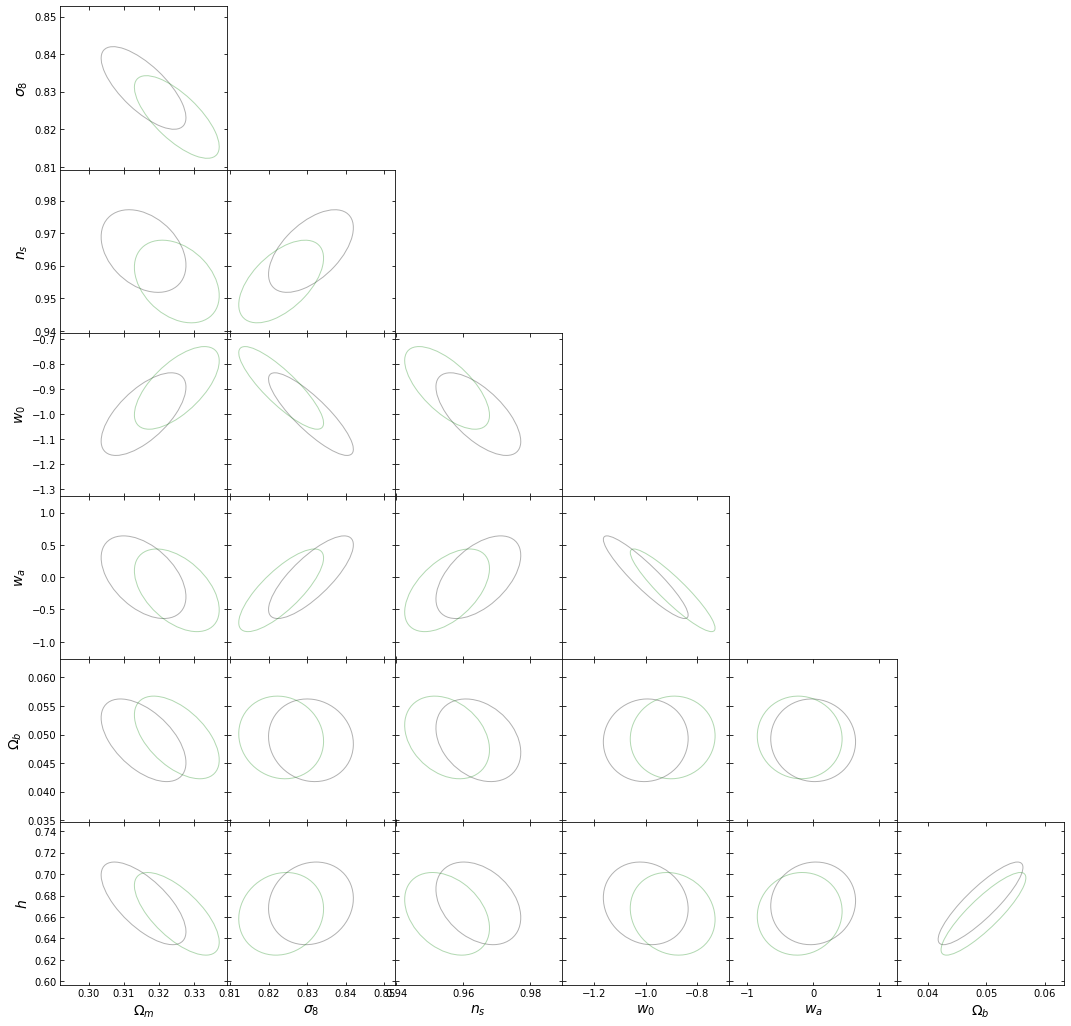


Fit by ***Exponential + const.***. 

Parameter       Fiducial Value  Sigma           Shift / Sigma  
omega_m         0.3156          0.0079          1.1919         
sigma_8         0.831           0.0072          -1.0679        
n_s             0.9645          0.0083          -1.1206        
w_0             -1              0.1083          0.965          
w_a             0               0.421           -0.4822        
omega_b         0.049           0.0048          0.1043         
h               0.6727          0.0254          -0.3847        


In [198]:
plot_all_param(para_bias1,nonlinear)

print('Fit by ***Exponential + const.***. \n')

printoutshift(para_bias1,nonlinear)

In [199]:
print(np.array(cell_bias1).shape)

(15, 15)


In [200]:
xip_bias2 = data2xip(lst,explaw,exp_polys)
cell_bias2 = xip2cl(theta_rad, xip_bias2, ell_bound)
para_bias2 = Cell2parambias(cell_bias2, nonlinear, param_order )
print(para_bias2)

/var/folders/cw/jqrw84tx2jb5fj92jz93n91r0000gn/T/ipykernel_11049/2781618143.py:33: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mat_t=mat_r_dr[slc]


{'omega_m': 0.012941874728246323, 'sigma_8': -0.010520465380657084, 'n_s': -0.012999679043669544, 'w_0': 0.14349248279306992, 'w_a': -0.2674019502595328, 'omega_b': 0.0006958283500476669, 'h': -0.013030124519264687, 'A0': -0.10719576535449153, 'beta': 0.005675711587075593, 'etal': -0.041157279475854486, 'etah': -0.10237649843360774}


/var/folders/cw/jqrw84tx2jb5fj92jz93n91r0000gn/T/ipykernel_11049/3478226968.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  bias_vec.append(sum(diff_cl[idx].dot(


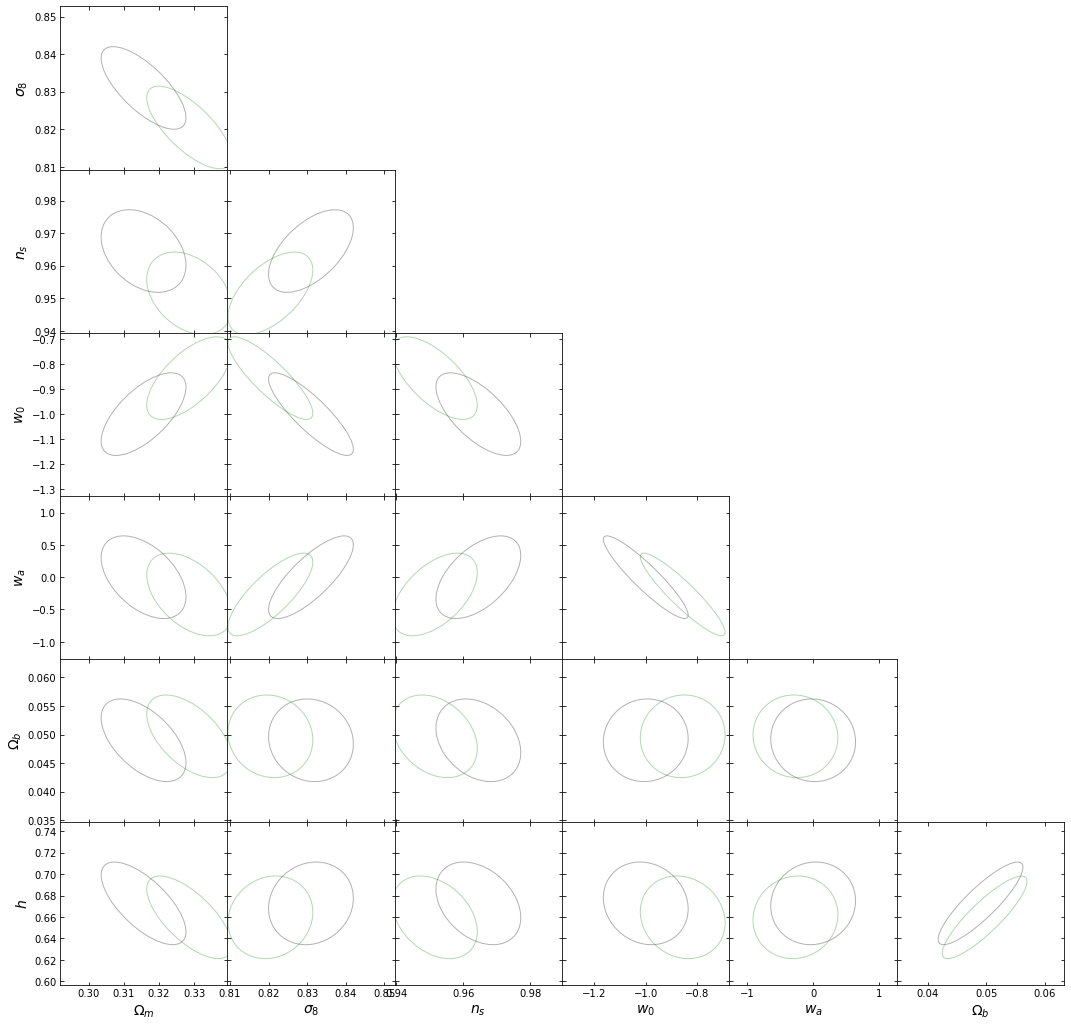


Fit by ***Exponential***. 

Parameter       Fiducial Value  Sigma           Shift / Sigma  
omega_m         0.3156          0.0079          1.6336         
sigma_8         0.831           0.0072          -1.453         
n_s             0.9645          0.0083          -1.5587        
w_0             -1              0.1083          1.3244         
w_a             0               0.421           -0.6351        
omega_b         0.049           0.0048          0.1462         
h               0.6727          0.0254          -0.5133        


In [201]:
plot_all_param(para_bias2,nonlinear)

print('Fit by ***Exponential***. \n')

printoutshift(para_bias2,nonlinear)

In [202]:
print(type(cov))

<class 'function'>


In [203]:
xip_bias3 = data2xip(lst, powerlaw, power_polys)
cell_bias3 = xip2cl(theta_rad, xip_bias3, ell_bound)
para_bias3 = Cell2parambias(cell_bias3, nonlinear, param_order )
print(para_bias3)

/var/folders/cw/jqrw84tx2jb5fj92jz93n91r0000gn/T/ipykernel_11049/2781618143.py:33: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mat_t=mat_r_dr[slc]


{'omega_m': 0.006711013056267261, 'sigma_8': -0.006255814014357972, 'n_s': -0.0059194123920930045, 'w_0': 0.08812509377296217, 'w_a': -0.20552452643077396, 'omega_b': 0.000652634741164724, 'h': -0.007391355777946121, 'A0': -0.12201228455006916, 'beta': 0.0005650686099519548, 'etal': -0.004489199130617327, 'etah': -0.07106460228142714}


/var/folders/cw/jqrw84tx2jb5fj92jz93n91r0000gn/T/ipykernel_11049/3478226968.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  bias_vec.append(sum(diff_cl[idx].dot(


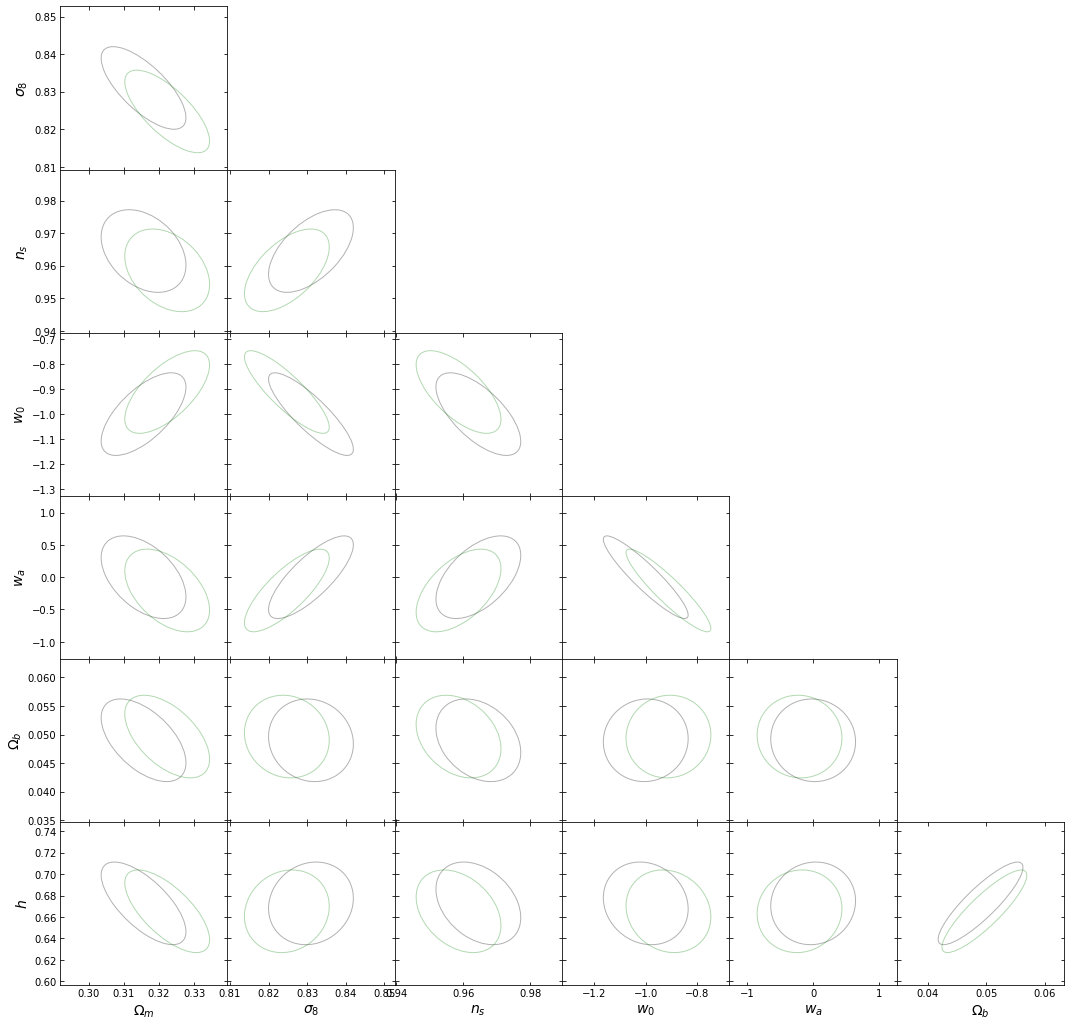


Fit by ***Power Law***. 

Parameter       Fiducial Value  Sigma           Shift / Sigma  
omega_m         0.3156          0.0079          0.8471         
sigma_8         0.831           0.0072          -0.864         
n_s             0.9645          0.0083          -0.7098        
w_0             -1              0.1083          0.8134         
w_a             0               0.421           -0.4881        
omega_b         0.049           0.0048          0.1371         
h               0.6727          0.0254          -0.2911        


In [204]:
plot_all_param(para_bias3,nonlinear)

print('Fit by ***Power Law***. \n')


printoutshift(para_bias3,nonlinear)

In [33]:
xip_bias4 = data2xip(lst, twoexp, twoexp_polys)
print(len(xip_bias4[0]))
cell_bias4 = xip2cl(theta_rad, xip_bias4, ell_bound)

para_bias4 = Cell2parambias(cell_bias4, nonlinear, param_order )
print(para_bias4)

10000


/var/folders/cw/jqrw84tx2jb5fj92jz93n91r0000gn/T/ipykernel_33065/2781618143.py:33: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mat_t=mat_r_dr[slc]


{'omega_m': 0.0073365108630424536, 'sigma_8': -0.0058905872567288665, 'n_s': -0.006776987290427476, 'w_0': 0.0894846515642096, 'w_a': -0.1581123348853304, 'omega_b': 0.000795296715652187, 'h': -0.009577872066969795, 'A0': -0.1543940084515498, 'beta': -0.0026555464447282078, 'etal': -0.0015192721435973167, 'etah': -0.0001089383357231586}


/var/folders/cw/jqrw84tx2jb5fj92jz93n91r0000gn/T/ipykernel_33065/3478226968.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  bias_vec.append(sum(diff_cl[idx].dot(


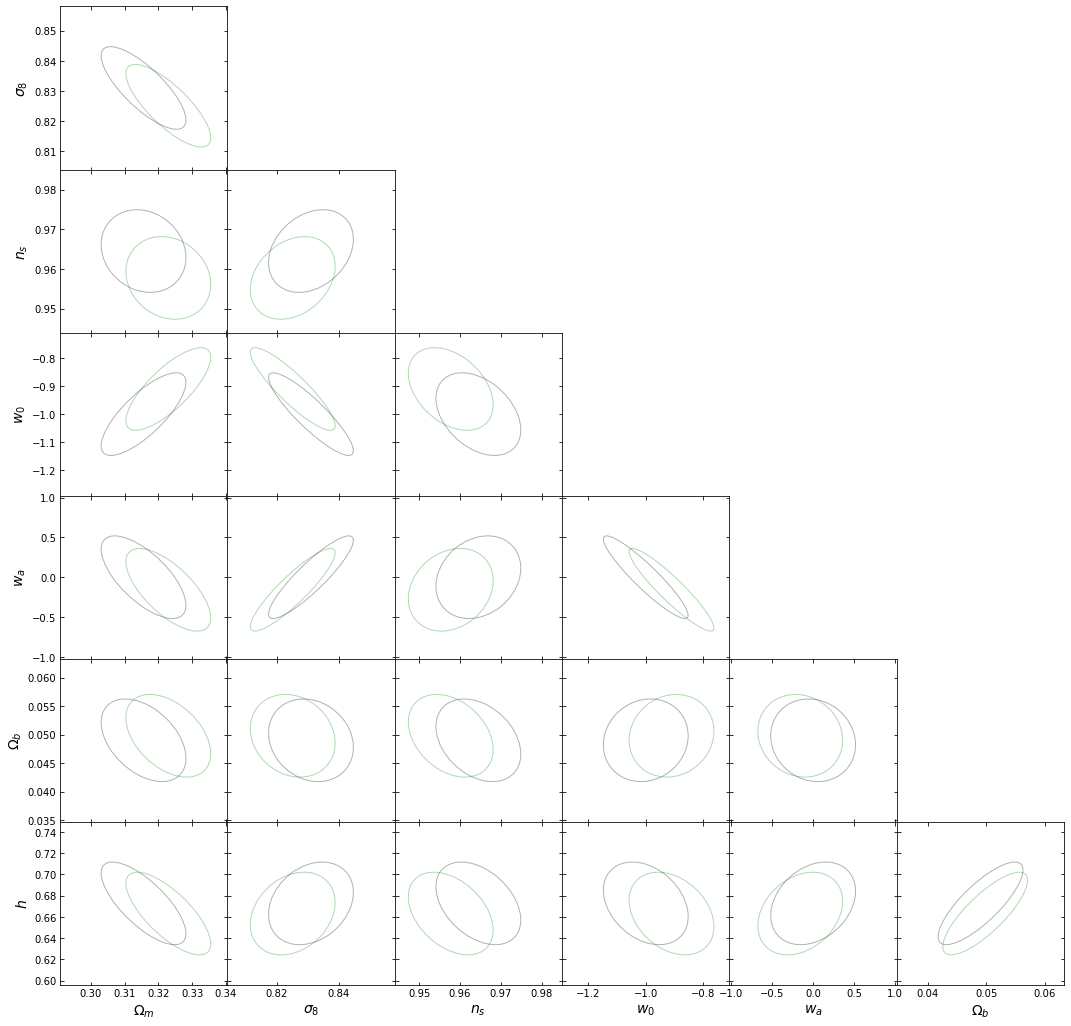


Fit by ***Double Exponential***. 

Parameter       Fiducial Value  Sigma           Shift / Sigma  
omega_m         0.3156          0.0083          0.8874         
sigma_8         0.831           0.009           -0.6538        
n_s             0.9645          0.0068          -0.9897        
w_0             -1              0.0968          0.9241         
w_a             0               0.3414          -0.4631        
omega_b         0.049           0.0048          0.1665         
h               0.6727          0.0256          -0.3741        
[0.887415495911831, -0.6538278141210146, 0.9241132954996074, -0.46309122956780285]
average shift: 0.7321119587750641


In [84]:
plot_all_param(para_bias4,nonlinear)

print('Fit by ***Double Exponential***. \n')


printoutshift(para_bias4,nonlinear)

In [62]:
nonlinear.fisher

array([[ 9.41234506e+06,  7.09085706e+06,  9.31207864e+05,
        -3.38442950e+05, -1.13216914e+05,  7.21420733e+06,
         5.91254688e+05,  2.56659918e+04,  1.95955560e+05,
         3.23900629e+04,  1.86623814e+04],
       [ 7.09085706e+06,  5.51867849e+06,  7.33116287e+05,
        -2.90947180e+05, -9.38750123e+04,  5.40279231e+06,
         4.57832089e+05, -2.43826017e+03,  8.84705905e+04,
        -2.06025359e+04,  1.54077926e+04],
       [ 9.31207864e+05,  7.33116287e+05,  2.26971537e+05,
        -4.94762660e+04, -1.42619216e+04,  5.11310331e+05,
         1.14800135e+05, -1.34788481e+04, -5.71604712e+04,
        -3.20965600e+04,  6.79848126e+02],
       [-3.38442950e+05, -2.90947180e+05, -4.94762660e+04,
         3.05579148e+04,  7.46461079e+03, -2.34275791e+05,
        -2.82299928e+04,  9.17616593e+03,  3.43949767e+04,
         1.96583197e+04, -5.25300651e+02],
       [-1.13216914e+05, -9.38750123e+04, -1.42619216e+04,
         7.46461079e+03,  2.05166671e+03, -8.12512755e+04,
  

In [154]:
print(exp_polys)
print(twoexp_polys)

[array([1.85785394e-07, 4.84903303e-07]), array([-0.003935  ,  0.10525293])]
[array([-3.99091235e-08,  6.21893580e-07]), array([-0.0789855 ,  0.33947225]), array([ 2.35973061e-07, -1.04048215e-07]), array([ 0.0695455 , -0.07734198])]


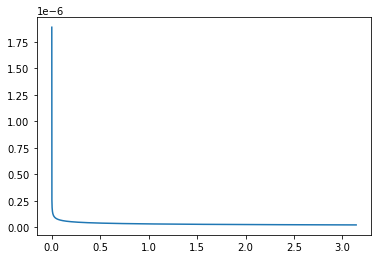

In [151]:
plt.plot(theta_rad,xip_bias3[0] )

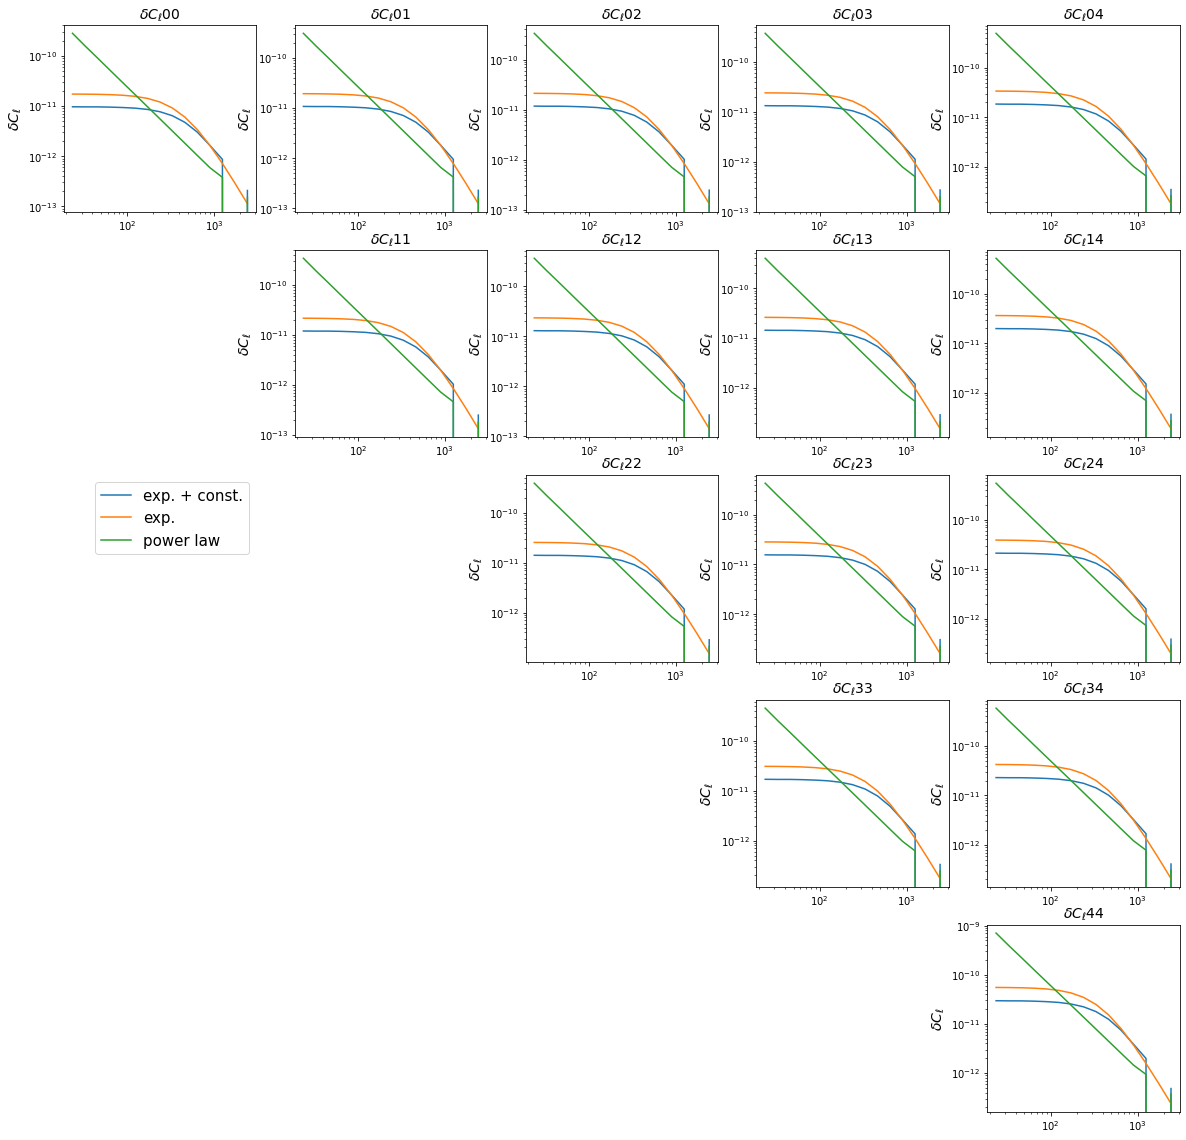

In [123]:
plt.figure(figsize = (20,20))
cl_unbiased = np.array(nonlinear.ccl_cls['C_ell']).reshape(15, 15)

count = 0
for i in range(5):
    for j in range(i,5):
        #ell_fit = 
        plt.subplot(5,5,5*i+j+1)
        
        plt.plot(ell, cell_bias1[count], label = 'exp. + const.' )

        plt.plot(ell, cell_bias2[count], label = 'exp.' )

        plt.plot(ell, cell_bias3[count], label = 'power law' )
        count+=1
        plt.xscale('log')
        plt.yscale('log')
        
        plt.title(r'$\delta C_\ell$' + str(i)+str(j))
        #plt.xlabel(r'$\ell$')
        plt.ylabel(r'$\delta C_\ell$')

        
plt.subplot(5,5,11)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
ax.axis('off')
plt.plot([0],[0],label = 'exp. + const.' )
plt.plot([0],[0],label = 'exp.' )
plt.plot([0],[0],label = 'power law' )

plt.legend(fontsize = 15)

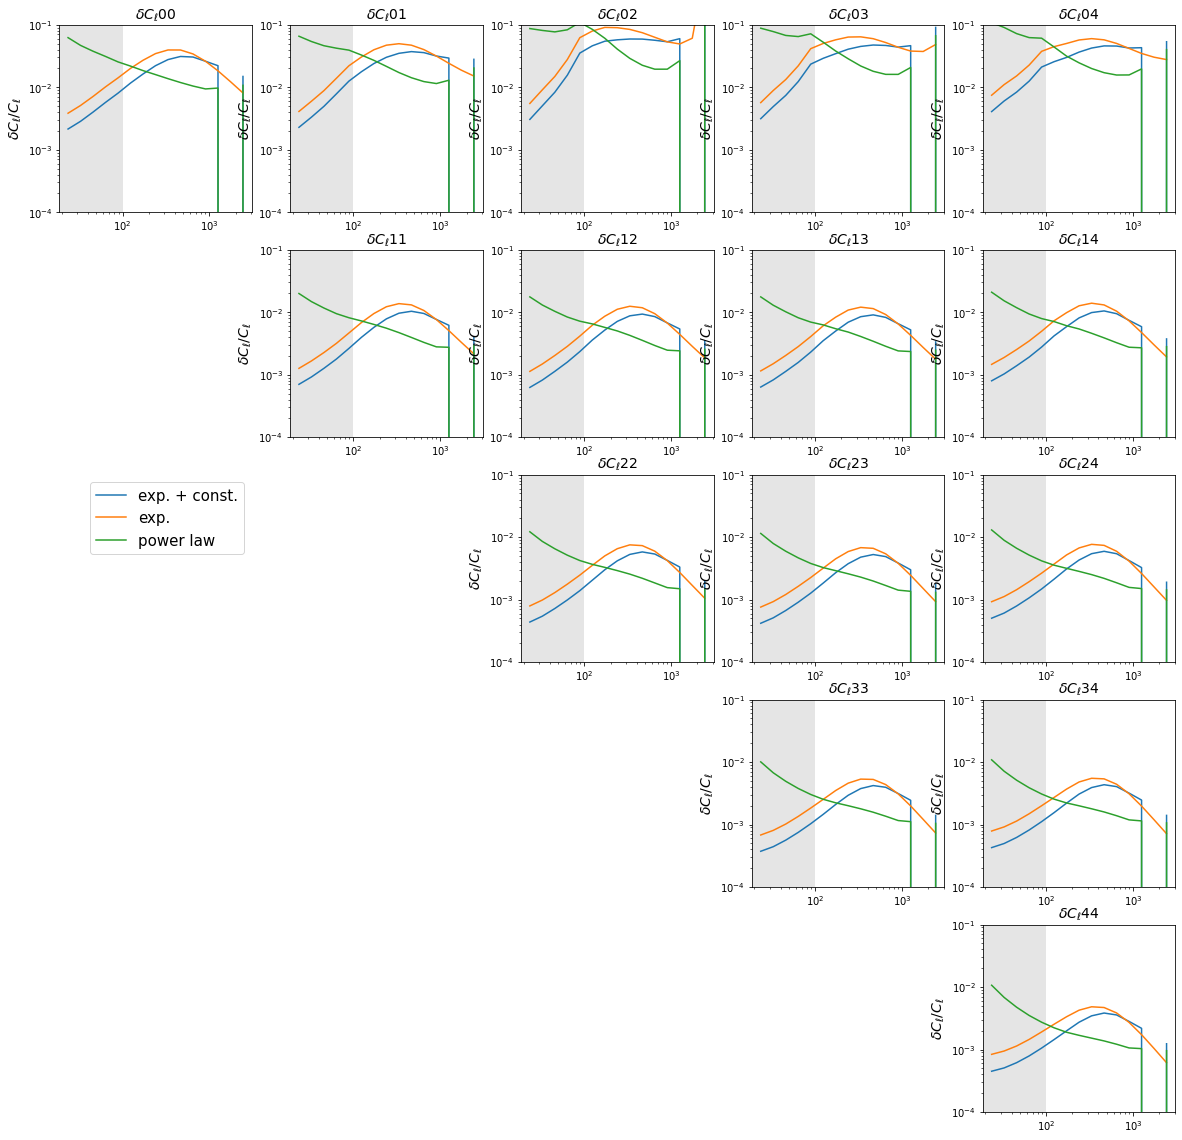

In [124]:
plt.figure(figsize = (20,20))
cl_unbiased = np.array(nonlinear.ccl_cls['C_ell']).reshape(15, 15)

count = 0
for i in range(5):
    for j in range(i,5):
        #ell_fit = 
        plt.subplot(5,5,5*i+j+1)
        
        plt.plot(ell, cell_bias1[count]/cl_unbiased[count], label = 'exp. + const.' )

        plt.plot(ell, cell_bias2[count]/cl_unbiased[count], label = 'exp.' )

        plt.plot(ell, cell_bias3[count]/cl_unbiased[count], label = 'power law' )
        count+=1
        plt.xscale('log')
        plt.yscale('log')
        
        plt.title(r'$\delta C_\ell$' + str(i)+str(j))
        #plt.xlabel(r'$\ell$')
        plt.ylabel(r'$\delta C_\ell / C_\ell$')
        plt.ylim([0.0001,0.1])
        
        plt.fill_between([0,100], 0, 1, color = 'black',alpha = 0.1,edgecolor = 'white',linewidth=0.0)

        
plt.subplot(5,5,11)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
ax.axis('off')
plt.plot([0],[0],label = 'exp. + const.' )
plt.plot([0],[0],label = 'exp.' )
plt.plot([0],[0],label = 'power law' )

plt.legend(fontsize = 15)

In [125]:
param_order

['omega_m',
 'sigma_8',
 'n_s',
 'w_0',
 'w_a',
 'omega_b',
 'h',
 'A0',
 'beta',
 'etal',
 'etah']

In [127]:
cl_unbiased = np.array(nonlinear.ccl_cls['C_ell']).reshape(15, 15)
cl_biased = []
count = 0
for i in range(5):
    for j in range(i,5):
        this_biased = cl_unbiased[count]+cell_bias2[count]
        cl_biased.append(this_biased)
        count+=1
cl_biased = np.array(cl_biased)
cl_unbiased = cl_unbiased.T
cl_biased = cl_biased.T

#diff_cl = np.column_stack(cl_biased - cl_unbiased)
diff_cl = cl_biased - cl_unbiased


weight_dict = {}
contribution_dict = {}
for param in param_order:
    weight_dict[param] = np.zeros(shape = (15,15))
    contribution_dict[param] = np.zeros(shape = (15,15))
    for i in range(15):
        weight_dict[param][i] = np.array(nonlinear.invcov_list[i]).dot(nonlinear.derivs_sig[param][i])
        #print(diff_cl[i].shape)
        contribution_dict[param][i] = diff_cl[i] * weight_dict[param][i]
    weight_dict[param] = weight_dict[param].T
    contribution_dict[param] = contribution_dict[param].T

In [128]:
plt.figure(figsize = (20,20))
cl_unbiased = np.array(no_outliers.ccl_cls['C_ell']).reshape(15, 15)



count = 0
for i in range(5):
    for j in range(i,5):
        #ell_fit = 
        plt.subplot(5,5,5*i+j+1)
        
        #for k, param in enumerate(param_order):
        plt.plot(no_outliers.ell, weight_dict['n_s'][count])
        plt.plot(no_outliers.ell, weight_dict['w_0'][count] )
        plt.plot(no_outliers.ell, weight_dict['w_a'][count])
        plt.plot(no_outliers.ell, weight_dict['h'][count] )


#        plt.plot(no_outliers.ell, np.array(no_outliers.invcov_list[count]).dot(no_outliers.derivs_sig['n_s'][count]), label = 'exp. + const.' )
#        plt.plot(no_outliers.ell, np.array(no_outliers.invcov_list[count]).dot(no_outliers.derivs_sig['w_0'][count]), label = 'exp. + const.' )
#        plt.plot(no_outliers.ell, np.array(no_outliers.invcov_list[count]).dot(no_outliers.derivs_sig['w_a'][count]), label = 'exp. + const.' )
#        plt.plot(no_outliers.ell, np.array(no_outliers.invcov_list[count]).dot(no_outliers.derivs_sig['h'][count]), label = 'exp. + const.' )

        count+=1
        plt.xscale('log')
        plt.yscale('symlog',linthresh=4e11 )
        
        plt.title(r'$\delta C_\ell$' + str(i)+str(j))
        plt.ylim([-1e14, 1e14])
        #plt.xlabel(r'$\ell$')
        #plt.ylabel(r'$\delta C_\ell$')

plt.subplot(5,5,11)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
ax.axis('off')
plt.plot([0],[0],label = 'n_s' )
plt.plot([0],[0],label = 'w_0' )
plt.plot([0],[0],label = 'w_a' )
plt.plot([0],[0],label = 'h' )



plt.legend(fontsize = 15)

NameError: name 'no_outliers' is not defined

<Figure size 1440x1440 with 0 Axes>

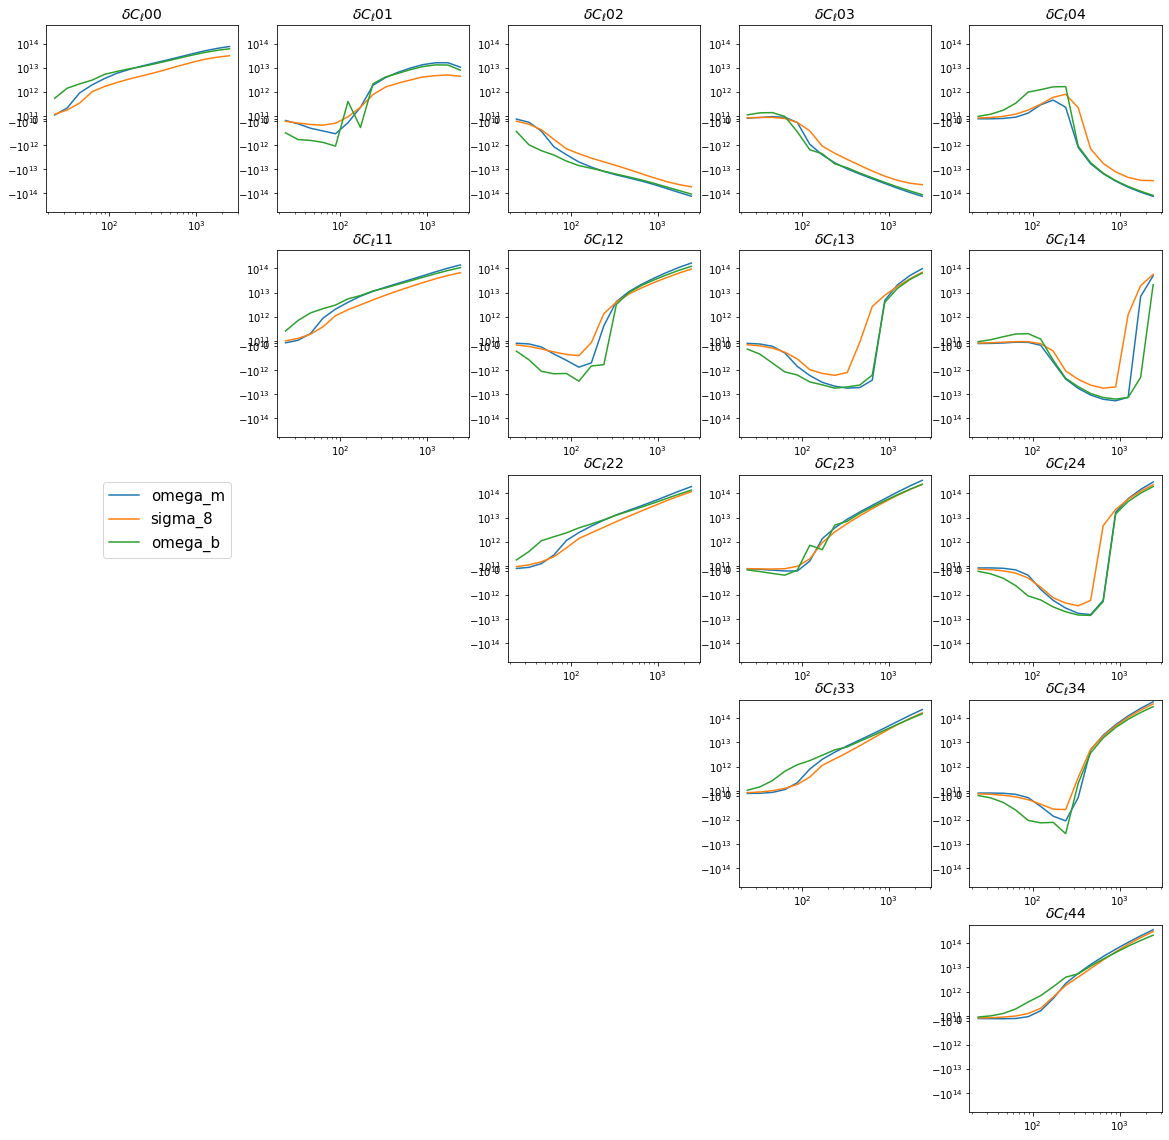

In [48]:
plt.figure(figsize = (20,20))
cl_unbiased = np.array(no_outliers.ccl_cls['C_ell']).reshape(15, 15)

count = 0
for i in range(5):
    for j in range(i,5):
        #ell_fit = 
        plt.subplot(5,5,5*i+j+1)
        
        #for k, param in enumerate(param_order):
        plt.plot(no_outliers.ell, weight_dict['omega_m'][count])
        plt.plot(no_outliers.ell, weight_dict['sigma_8'][count])
        plt.plot(no_outliers.ell, weight_dict['omega_b'][count])
        

#         plt.plot(no_outliers.ell, np.array(no_outliers.invcov_list[count]).dot(no_outliers.derivs_sig['omega_m'][count]), label = 'exp. + const.' )
#         plt.plot(no_outliers.ell, np.array(no_outliers.invcov_list[count]).dot(no_outliers.derivs_sig['sigma_8'][count]), label = 'exp. + const.' )
#         plt.plot(no_outliers.ell, np.array(no_outliers.invcov_list[count]).dot(no_outliers.derivs_sig['omega_b'][count]), label = 'exp. + const.' )
#         #plt.plot(no_outliers.ell, np.array(no_outliers.invcov_list[count]).dot(no_outliers.derivs_sig['h'][count]), label = 'exp. + const.' )

        count+=1
        plt.xscale('log')
        plt.yscale('symlog', linthresh=10e11 )
        plt.ylim([-6e14, 6e14])

        plt.title(r'$\delta C_\ell$' + str(i)+str(j))
        #plt.xlabel(r'$\ell$')
        #plt.ylabel(r'$\delta C_\ell$')

plt.subplot(5,5,11)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
ax.axis('off')
plt.plot([0],[0],label = 'omega_m' )
plt.plot([0],[0],label = 'sigma_8' )
plt.plot([0],[0],label = 'omega_b' )


plt.legend(fontsize = 15)

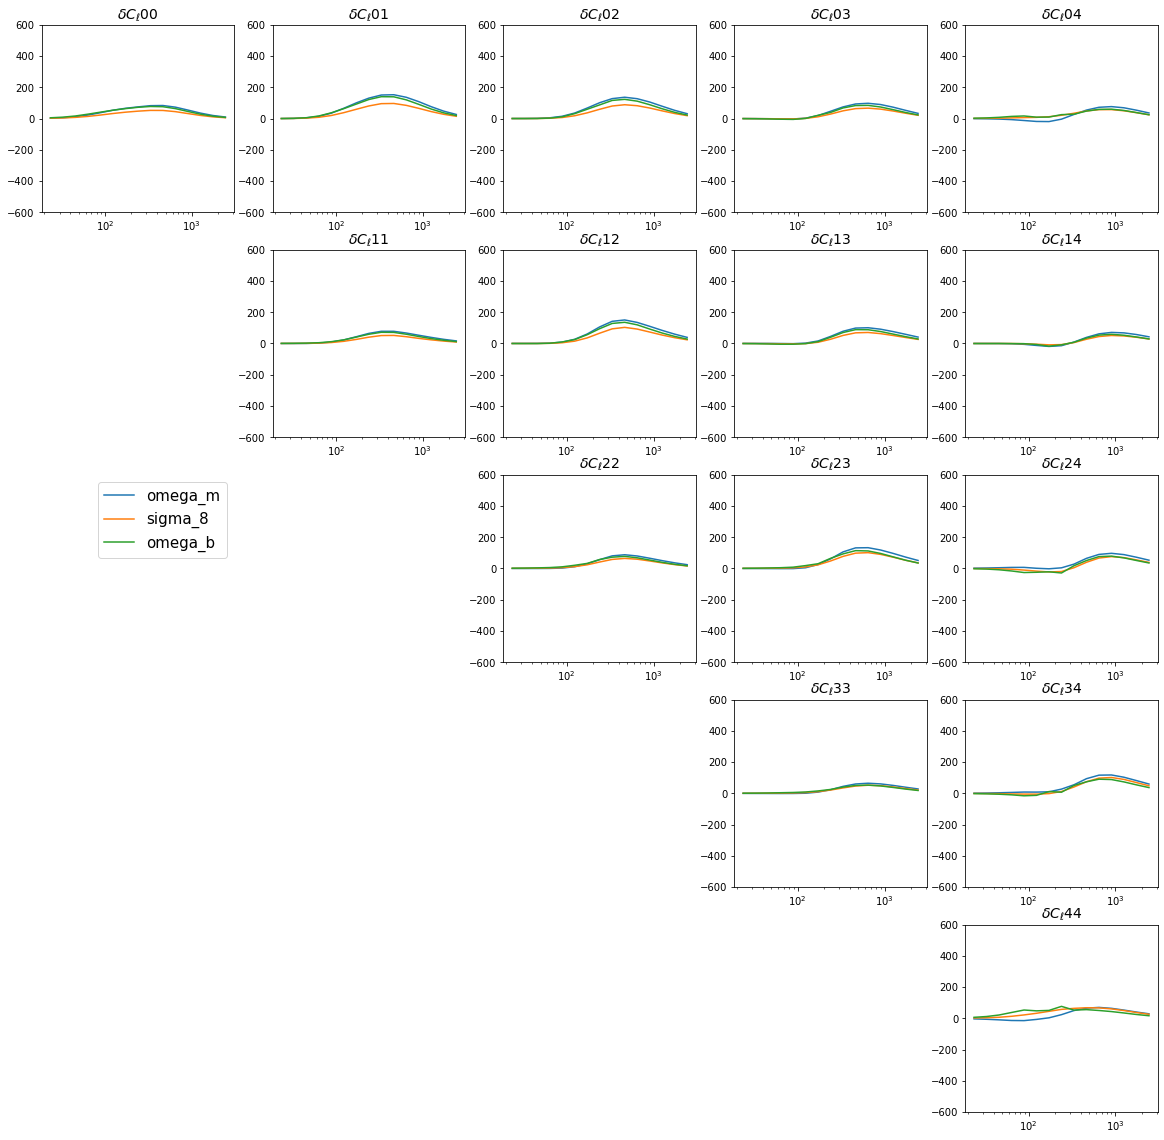

In [70]:
plt.figure(figsize = (20,20))
cl_unbiased = np.array(nonlinear.ccl_cls['C_ell']).reshape(15, 15)
cl_biased = []
count = 0
for i in range(5):
    for j in range(i,5):
        this_biased = cl_unbiased[count]+cell_bias2[count]
        cl_biased.append(this_biased)
        count+=1
cl_biased = np.array(cl_biased)
cl_unbiased = cl_unbiased.T
cl_biased = cl_biased.T



#diff_cl = np.column_stack(cl_biased - cl_unbiased)
diff_cl = cl_biased - cl_unbiased
count = 0
for i in range(5):
    for j in range(i,5):
        #ell_fit = 
        plt.subplot(5,5,5*i+j+1)
        
        #for k, param in enumerate(param_order):

        plt.plot(ell,contribution_dict['omega_m'][count], label = 'exp. + const.' )
        plt.plot(ell,contribution_dict['sigma_8'][count], label = 'exp. + const.' )
        plt.plot(ell,contribution_dict['omega_b'][count], label = 'exp. + const.' )
        #plt.plot(no_outliers.ell, np.array(no_outliers.invcov_list[count]).dot(no_outliers.derivs_sig['h'][count]), label = 'exp. + const.' )

        count+=1
        plt.xscale('log')
        #plt.yscale('symlog',linthresh=10)
        plt.ylim([-600, 600])

        plt.title(r'$\delta C_\ell$' + str(i)+str(j))
        #plt.xlabel(r'$\ell$')
        #plt.ylabel(r'$\delta C_\ell$')

plt.subplot(5,5,11)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
ax.axis('off')
plt.plot([0],[0],label = 'omega_m' )
plt.plot([0],[0],label = 'sigma_8' )
plt.plot([0],[0],label = 'omega_b' )


plt.legend(fontsize = 15)

In [50]:
#From delta C_ell to parameter shift

def Cell2parambias2(bias_fisher_cl, no_outliers, param_order ):
    cl_unbiased = np.array(no_outliers.ccl_cls['C_ell']).reshape(15, 15)
    cl_biased = []
    count = 0
    for i in range(5):
        for j in range(i,5):
            this_biased = cl_unbiased[count]+bias_fisher_cl[count]
            cl_biased.append(this_biased)
            count+=1
    cl_biased = np.array(cl_biased)
    cl_unbiased = cl_unbiased.T
    cl_biased = cl_biased.T
    
    
    
    #diff_cl = np.column_stack(cl_biased - cl_unbiased)
    diff_cl = cl_biased - cl_unbiased
    bias_vec = []
    for i, param in enumerate(param_order):
        
        accumulate_bias = 0.0
        
        print(param)
        for idx in range(15):
            this_ell_bias = diff_cl[idx].dot(np.array(no_outliers.invcov_list[idx]).dot(no_outliers.derivs_sig[param][idx]))
            weight_on_ells = np.array(no_outliers.invcov_list[idx]).dot(no_outliers.derivs_sig[param][idx])
            accumulate_bias+=this_ell_bias
            
            print(idx, diff_cl[idx])
        
        bias_vec.append(accumulate_bias)
        
    print(bias_vec)

    bias_vec = np.array(bias_vec)
    para_bias = np.linalg.inv(1/400*no_outliers.fisher).dot(bias_vec) 
    para_bias = {param_order[i]: para_bias[i] for i in range(7)}
    
    return para_bias
    
    

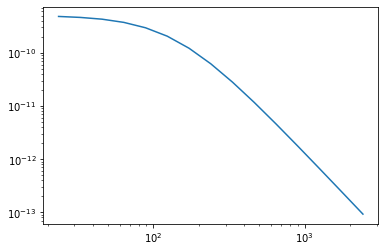

In [70]:
plt.plot(no_outliers.ell, cell_bias2[-1])
plt.yscale('log')
plt.xscale('log')


In [168]:
print(cell_bias1[-1])

[2.83391852e-11 2.82441572e-11 2.80667450e-11 2.77235342e-11
 2.70846505e-11 2.59232501e-11 2.38997079e-11 2.06621515e-11
 1.61599137e-11 1.10304559e-11 6.43510461e-12 3.23384677e-12
 1.44435848e-12 5.95568984e-13 2.33979725e-13]


In [202]:


para_bias = Cell2parambias2(cell_bias2, no_outliers, param_order )
print(para_bias)

omega_m
0 [2.12644490e-11 2.60871806e-11 3.09464179e-11 3.87221246e-11
 8.54074365e-11 3.18312979e-11 3.76572132e-11 4.70554710e-11
 1.05185945e-10 4.45065408e-11 5.56416318e-11 1.26538518e-10
 6.97645214e-11 1.63793190e-10 4.80573831e-10]
1 [2.11620188e-11 2.59487062e-11 3.07671979e-11 3.84686927e-11
 8.44878251e-11 3.16441875e-11 3.74145908e-11 4.67104937e-11
 1.03875119e-10 4.41908656e-11 5.51896347e-11 1.24735124e-10
 6.91091036e-11 1.60959646e-10 4.60720895e-10]
2 [2.09714783e-11 2.56914292e-11 3.04346159e-11 3.79992694e-11
 8.28021232e-11 3.12970377e-11 3.69650762e-11 4.60727443e-11
 1.01482311e-10 4.36069422e-11 5.43556741e-11 1.21457654e-10
 6.79036093e-11 1.55848446e-10 4.26950516e-10]
3 [2.06054223e-11 2.51983089e-11 2.97986104e-11 3.71047566e-11
 7.96524939e-11 3.06334457e-11 3.61080901e-11 4.48619516e-11
 9.70462458e-11 4.24971008e-11 5.27782199e-11 1.15431018e-10
 6.56368510e-11 1.46578798e-10 3.71725370e-10]
4 [1.99327918e-11 2.42960908e-11 2.86398623e-11 3.54856402e-11
 

In [18]:
print(np.array(no_outliers.invcov_list).shape)

(20, 15, 15)


In [51]:
##Multiplicative bias

xip_bias3 = data2xip(lst, poly1_m6, poly2_m6, model6)
cell_bias3 = xip2cl(theta_rad, xip_bias3, ell_bound)
para_bias3 = Cell2parambias(cell_bias3, no_outliers, param_order )
print(para_bias3)

/Users/zhangtianqing/miniconda2/envs/DL_env/lib/python3.6/site-packages/ipykernel_launcher.py:33: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


{'omega_m': 0.00020070502894355743, 'sigma_8': -0.0004980089692572876, 'n_s': -2.21782896355667e-05, 'w_0': -0.014228559425560044, 'w_a': 0.04310238928206614, 'omega_b': 0.0004489919290120172, 'h': -0.0008968883860296477}


/Users/zhangtianqing/miniconda2/envs/DL_env/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


In [46]:
params_mul = [-0.00033467,  0.00113895,  0.0007727 ]


In [47]:
def m_model(z,a,b,c):
    return a*z**2+b*z+c

In [53]:
#build full_cl

def full_cl(no_outliers):
    cosmo = no_outliers.cosmo
    ccl_cls = pd.DataFrame()
    zbin = 0
    j = 0
    ia0 = no_outliers.A0 * np.array([no_outliers.A_l(zi, no_outliers.etal) for zi in no_outliers.zmid]) * np.array([no_outliers.A_h(zi, no_outliers.etah) for zi in no_outliers.zmid])
    lst = list(no_outliers.dNdz_dict_source.keys())
    full_ell = np.arange(1,3072,1)
    for i, key in enumerate(lst):
        ia = no_outliers.getAi(no_outliers.beta, cosmo, dndz=(tuple(no_outliers.zmid), tuple(no_outliers.dNdz_dict_source[key]))) * ia0
        lens1 = ccl.WeakLensingTracer(cosmo, dndz=(no_outliers.zmid, no_outliers.dNdz_dict_source[key]), ia_bias=(no_outliers.zmid, ia))
        for keyj in lst[i:]:

            print(key, keyj)
            ia = no_outliers.getAi(no_outliers.beta, cosmo, dndz=(tuple(no_outliers.zmid), tuple(no_outliers.dNdz_dict_source[keyj]))) * ia0
            lens2 = ccl.WeakLensingTracer(cosmo, dndz=(no_outliers.zmid, no_outliers.dNdz_dict_source[keyj]), ia_bias=(no_outliers.zmid, ia))
            cls = ccl.angular_cl(cosmo, lens1, lens2, full_ell)
            newdf = pd.DataFrame({'zbin': [int(k) for k in j*np.ones(len(cls))],
                                  'ell': full_ell,
                                  'C_ell': cls})
            ccl_cls = pd.concat((ccl_cls, newdf))
            j += 1


    ccl_cls = ccl_cls.reset_index()

    C_ells = []
    for i in set(ccl_cls['zbin']):
        C_ells.append(list(ccl_cls[ccl_cls['zbin']==i]['C_ell']))
        
    return np.array(C_ells)
    
    
    
    
    
    

In [54]:
nonlinear.cosmo

pyccl.Cosmology(Omega_c=0.2666, Omega_b=0.049, h=0.6727, n_s=0.9645, sigma8=0.831, A_s=None, Omega_k=0.0, Omega_g=None, Neff=3.046, w0=-1.0, wa=0.0, T_CMB=None, bcm_log10Mc=14.079181246047625, bcm_etab=0.5, bcm_ks=55.0, mu_0=0.0, sigma_0=0.0, c1_mg=1.0, c2_mg=1.0, lambda_mg=0.0, extra_parameters=None, m_nu=0.0, m_nu_type=None, z_mg=None, df_mg=None, transfer_function='eisenstein_hu', matter_power_spectrum='halofit', baryons_power_spectrum='nobaryons', mass_function='tinker10', halo_concentration='duffy2008', emulator_neutrinos='strict')

In [55]:
#linear_full_cell = full_cl(linear)
nonlinear_full_cell = full_cl(nonlinear)
full_ell = np.arange(1,3072,1)

0.30000000000000004 0.30000000000000004
0.30000000000000004 0.65
0.30000000000000004 0.95
0.30000000000000004 1.35
0.30000000000000004 2.75
0.65 0.65
0.65 0.95
0.65 1.35
0.65 2.75
0.95 0.95
0.95 1.35
0.95 2.75
1.35 1.35
1.35 2.75
2.75 2.75


In [71]:
#def linear_xip_mul(lst):

def xip_bias_multiplicative(m_model, params_mul,full_cell,fisher):
    count = 0
    xip_error = []
    for i in range(5):
        for j in range(i,5):
            this_cl = full_cell[count]
            xip_raw = ccl.correlations.correlation(fisher.cosmo, full_ell, this_cl, theta_deg, type = 'GG+')
            m = m_model(lst[i], *params_mul)+m_model(lst[j], *params_mul)
            xip_error.append(m*xip_raw)
            count+=1
    return xip_error

In [72]:
#def linear_xip_mul(lst):

def cell_bias_multiplicative(m_model, params_mul,fisher):
    cl_unbiased = np.array(fisher.ccl_cls['C_ell']).reshape(15, 15)
    count = 0
    cell_error = []
    for i in range(5):
        for j in range(i,5):
            this_cl = cl_unbiased[count]
            m = m_model(lst[i], *params_mul)+m_model(lst[j], *params_mul)
            cell_error.append(m*this_cl)
            count+=1
    return np.array(cell_error)

In [85]:
#xip_error = xip_bias_multiplicative(m_model, params_mul,nonlinear_full_cell,nonlinear)

#cell_bias_mul = xip2cl(theta_rad, xip_error, ell_bound)
cell_bias_mul = cell_bias_multiplicative(m_model, params_mul, nonlinear)

para_bias_mul = Cell2parambias(cell_bias_mul, nonlinear, param_order )


/var/folders/cw/jqrw84tx2jb5fj92jz93n91r0000gn/T/ipykernel_33065/3478226968.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  bias_vec.append(sum(diff_cl[idx].dot(


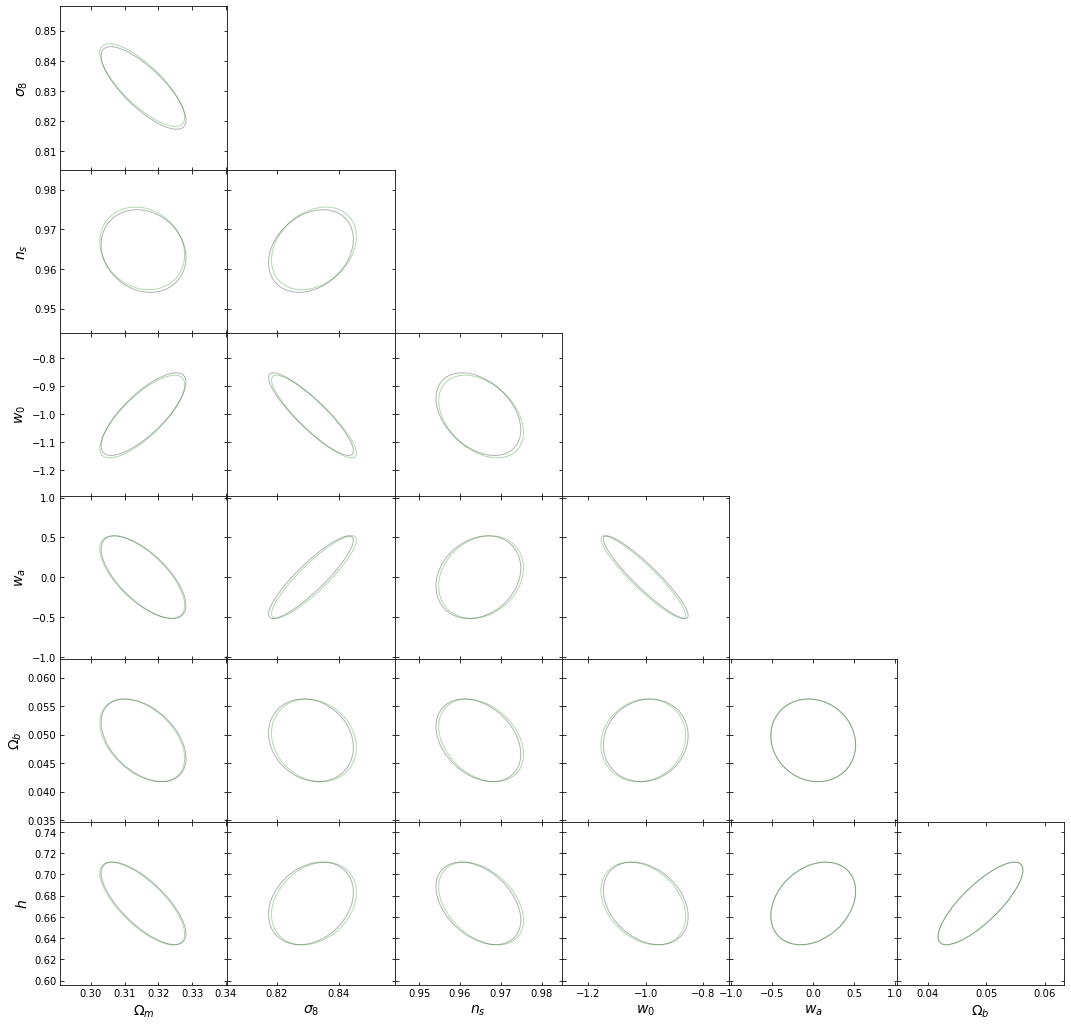


Multiplicative Bias 

Parameter       Fiducial Value  Sigma           Shift / Sigma  
omega_m         0.3156          0.0083          -0.0483        
sigma_8         0.831           0.009           0.1066         
n_s             0.9645          0.0068          0.0981         
w_0             -1              0.0968          -0.0885        
w_a             0               0.3414          0.0055         
omega_b         0.049           0.0048          -0.0051        
h               0.6727          0.0256          -0.0072        
[-0.048320675200921405, 0.10664633596748987, -0.08846226558797393, 0.005488858561847761]
average shift: 0.06222953382955824


In [86]:
plot_all_param(para_bias_mul,nonlinear,filename = '../plots2/pickle/cosmology_multiplicative.pkl')

print('Multiplicative Bias \n')


printoutshift(para_bias_mul,nonlinear)

In [36]:
a = np.array([[1,2,3],[4,5,6]])
b = np.array([[0,0,0],[0,0,0]])

ab = np.column_stack(a-b)

In [37]:
print(ab)

[[1 4]
 [2 5]
 [3 6]]


In [38]:
m0 = 0.003


In [107]:
#xip_error_const = xip_bias_multiplicative(m_model, [0,0,0.003])
#print(xip_error_const)
#cell_bias_mul_const = xip2cl(theta_rad, xip_error_const, ell_bound)
cell_bias_mul_const = cell_bias_multiplicative(m_model, [0,0,0.003], nonlinear)
#print(cell_bias_mul_const)
para_bias_mul_const = Cell2parambias(cell_bias_mul_const, nonlinear, param_order )


/var/folders/cw/jqrw84tx2jb5fj92jz93n91r0000gn/T/ipykernel_11049/3478226968.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  bias_vec.append(sum(diff_cl[idx].dot(


In [42]:
omega_m = 0.3156 
sigma_8 = 0.831

true_amp = sigma_8**2 * np.sqrt(omega_m)
obs_amp = 1.006*true_amp
fisher_amp = (sigma_8+para_bias_mul_const['sigma_8'])**2 * np.sqrt(omega_m+para_bias_mul_const['omega_m'])

In [43]:
print(true_amp)
print(obs_amp)
print(fisher_amp)

print('Expect amplitude of C_ell to increase by',(obs_amp-true_amp)/true_amp )
print('Fisher indicates that amplitude increase by ',(fisher_amp-true_amp)/true_amp )

0.387945344776745
0.3902730168454055
0.38759369874094923
Expect amplitude of C_ell to increase by 0.0059999999999999975
Fisher indicates that amplitude increase by  -0.0009064318995712126


In [108]:
plot_all_param(para_bias_mul_const,linear)
print('Multiplicative Bias with constant m(z) = 0.003 \n')


printoutshift(para_bias_mul_const,linear)

NameError: name 'linear' is not defined

In [113]:
xip_error_linear = xip_bias_multiplicative(m_model, [0,0.003*2/2.75,-0.003],linear_full_cell)

cell_bias_mul_linear = xip2cl(theta_rad, xip_error_linear, ell_bound)
#cell_bias_mul_linear = cell_bias_multiplicative(m_model, [0,0.003*2/2.75,-0.003])

para_bias_mul_linear = Cell2parambias(cell_bias_mul_linear, linear, param_order )


NameError: name 'linear_full_cell' is not defined

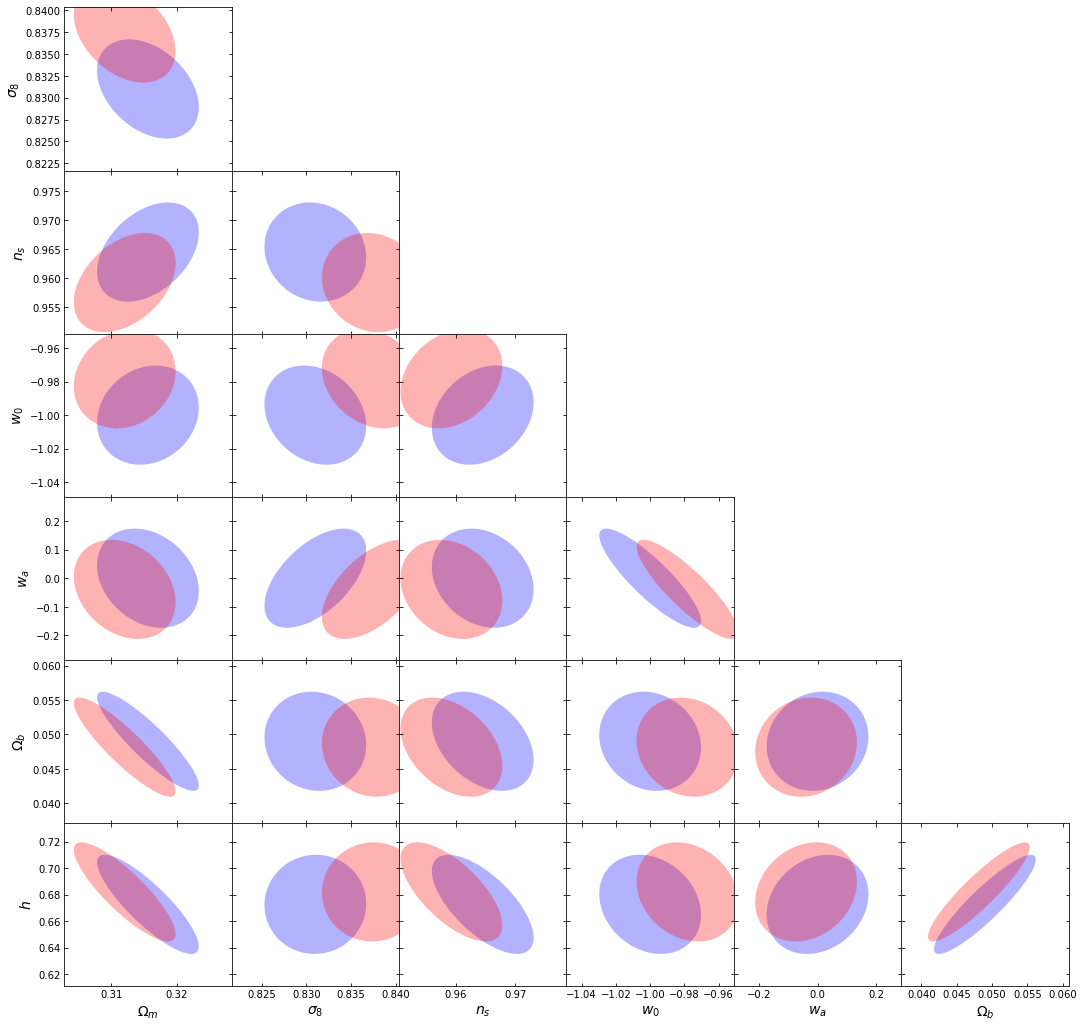


Multiplicative Bias with m(z) = 0.003(2z - z_max)/z_max 

Parameter       Fiducial Value  Sigma           Shift / Sigma  
omega_m         0.3156          0.0051          -0.6938        
sigma_8         0.831           0.0037          1.7168         
n_s             0.9645          0.0056          -0.9353        
w_0             -1              0.0195          1.115          
w_a             0               0.1142          -0.3427        
omega_b         0.049           0.0047          -0.1804        
h               0.6727          0.0246          0.3816         


In [204]:
plot_all_param(para_bias_mul_linear)

print('Multiplicative Bias with m(z) = 0.003(2z - z_max)/z_max \n')


printoutshift(para_bias_mul_linear)

No handles with labels found to put in legend.


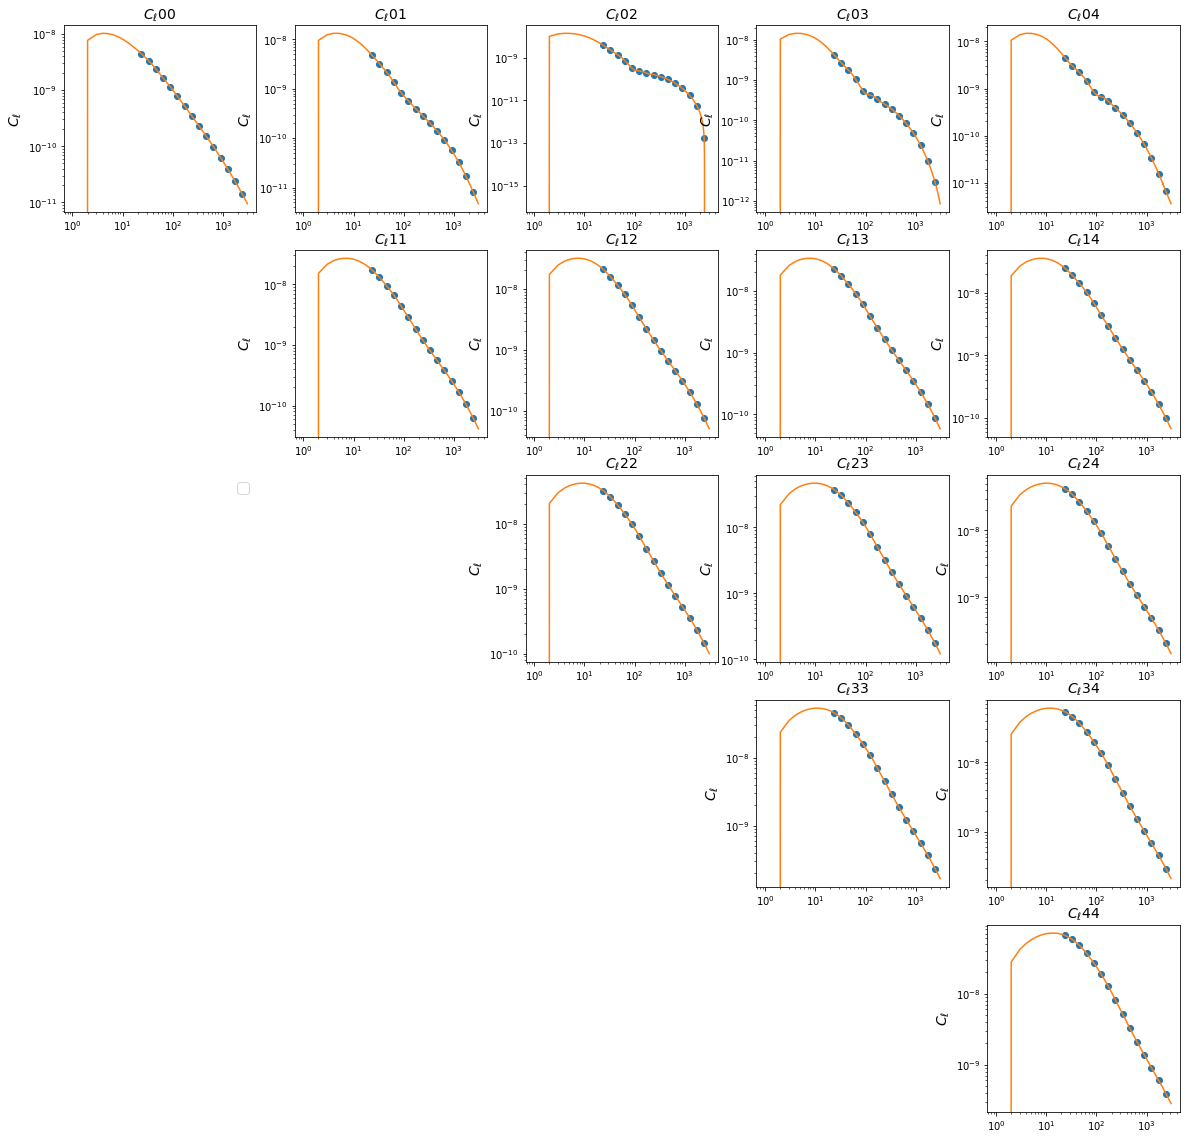

In [76]:
plt.figure(figsize = (20,20))
#cl_unbiased_linear = np.array(linear.ccl_cls['C_ell']).reshape(15, 15)
cl_unbiased_nonlinear = np.array(nonlinear.ccl_cls['C_ell']).reshape(15, 15)

count = 0
for i in range(5):
    for j in range(i,5):
        #ell_fit = 
        plt.subplot(5,5,5*i+j+1)
        
        #plt.plot(no_outliers.ell, cell_bias_mul_const[count]/cl_unbiased[count] )
        #plt.plot(no_outliers.ell, cell_bias_mul_linear[count]/cl_unbiased[count] )
        
        
        #plt.plot(ell, cl_unbiased_linear[count],'o', linewidth = 2.0)
        plt.plot(ell, cl_unbiased_nonlinear[count],'o', linewidth = 2.0)

        #plt.plot(full_ell, linear_full_cell[count])
        plt.plot(full_ell, nonlinear_full_cell[count])


        
        count+=1
        plt.xscale('log')
        plt.yscale('log')
        #plt.ylim([-0.008,0.008])
        plt.title(r'$C_\ell$' + str(i)+str(j))
        #plt.xlabel(r'$\ell$')
        plt.ylabel(r'$C_\ell$')

        
plt.subplot(5,5,11)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
ax.axis('off')
#plt.plot([0],[0],label = 'const. multiplicative' )
#plt.plot([0],[0],label = 'linear multiplicative' )

plt.legend(fontsize = 15)

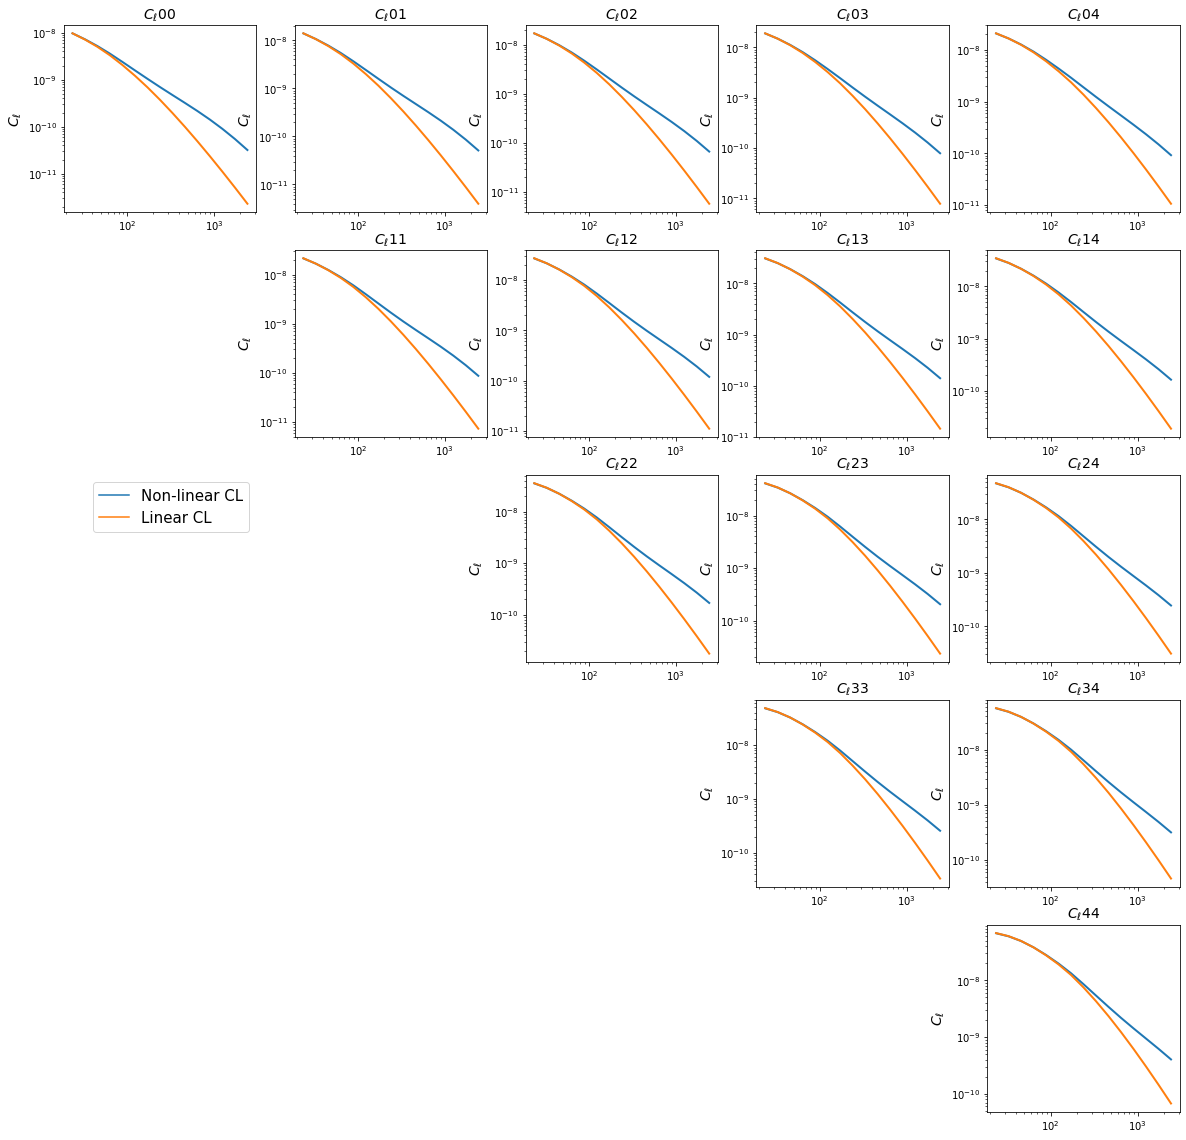

In [95]:
plt.figure(figsize = (20,20))
cl_unbiased_nonlinear = np.array(nonlinear.ccl_cls['C_ell']).reshape(15, 15)
cl_unbiased_linear = np.array(linear.ccl_cls['C_ell']).reshape(15, 15)

count = 0
for i in range(5):
    for j in range(i,5):
        #ell_fit = 
        plt.subplot(5,5,5*i+j+1)
        
        #plt.plot(no_outliers.ell, cell_bias_mul_const[count]/cl_unbiased[count] )
        #plt.plot(no_outliers.ell, cell_bias_mul_linear[count]/cl_unbiased[count] )
        
        
        plt.plot(ell, cl_unbiased_nonlinear[count], linewidth = 2.0)
        plt.plot(ell, cl_unbiased_linear[count], linewidth = 2.0)
        #plt.plot(full_ell, full_cell[count])

        
        count+=1
        plt.xscale('log')
        plt.yscale('log')
        #plt.ylim([-0.008,0.008])
        plt.title(r'$C_\ell$' + str(i)+str(j))
        #plt.xlabel(r'$\ell$')
        plt.ylabel(r'$C_\ell$')

        
plt.subplot(5,5,11)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
ax.axis('off')
plt.plot([0],[0],label = 'Non-linear CL' )
plt.plot([0],[0],label = 'Linear CL' )

plt.legend(fontsize = 15)

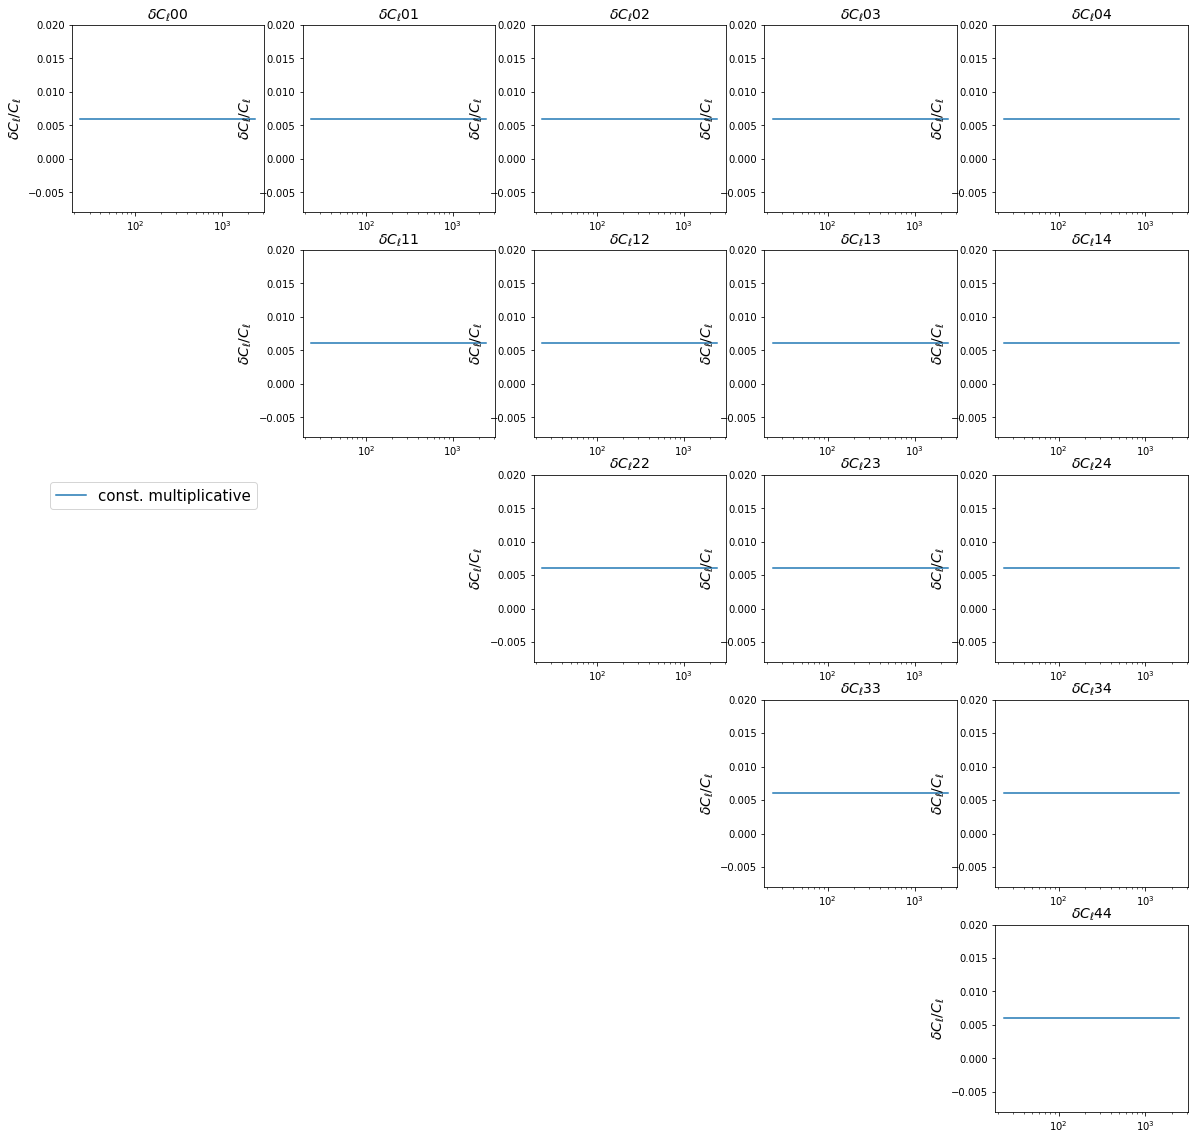

In [116]:
plt.figure(figsize = (20,20))
cl_unbiased = np.array(linear.ccl_cls['C_ell']).reshape(15, 15)

count = 0
for i in range(5):
    for j in range(i,5):
        #ell_fit = 
        plt.subplot(5,5,5*i+j+1)
        
        plt.plot(ell, cell_bias_mul_const[count]/cl_unbiased[count] )
        #plt.plot(no_outliers.ell, cell_bias_mul_linear[count]/cl_unbiased[count] )

        
        count+=1
        plt.xscale('log')
        #plt.yscale('log')
        plt.ylim([-0.008,0.02])
        plt.title(r'$\delta C_\ell$' + str(i)+str(j))
        #plt.xlabel(r'$\ell$')
        plt.ylabel(r'$\delta C_\ell / C_\ell$')

        
plt.subplot(5,5,11)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
ax.axis('off')
plt.plot([0],[0],label = 'const. multiplicative' )
#plt.plot([0],[0],label = 'linear multiplicative' )

plt.legend(fontsize = 15)

In [60]:
#From delta C_ell to parameter shift

def Cell2parambias_single(bias_fisher_cl, no_outliers, param_order, parameter ):
    cl_unbiased = np.array(no_outliers.ccl_cls['C_ell']).reshape(15, 15)
    cl_biased = []
    count = 0
    for i in range(5):
        for j in range(i,5):
            this_biased = cl_unbiased[count]+bias_fisher_cl[count]
            cl_biased.append(this_biased)
            count+=1
    cl_biased = np.array(cl_biased)
    cl_unbiased = cl_unbiased.T
    cl_biased = cl_biased.T
    
    
    
    #diff_cl = np.column_stack(cl_biased - cl_unbiased)
    diff_cl = cl_biased - cl_unbiased
    para_bias = dict()
    for i, param in enumerate(param_order):
        if param==parameter:
            fisher_element = no_outliers.fisher[i][i]
            bias_element = sum(diff_cl[idx].dot(
                np.array(no_outliers.invcov_list[idx]).dot(no_outliers.derivs_sig[param][idx])
                ) for idx in range(len(no_outliers.ell)))
            para_bias[param] = bias_element/fisher_element
        else:
            para_bias[param] = 0.0

    return para_bias
    
    

In [77]:
single_shift = Cell2parambias_single(cell_bias_mul_const, nonlinear, param_order, 'sigma_8' )

/Users/zhangtianqing/miniconda2/envs/DL_env/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


In [78]:
single_shift
sigma_shift = single_shift['sigma_8']

In [79]:
sigma_shift

0.0017897985685219075

In [80]:
sigma_8 = 0.831
print('d_sigma8/sigma8 = ',sigma_shift/sigma_8)
print('expect this to be 0.003')

d_sigma8/sigma8 =  0.002153788891121429
expect this to be 0.003


In [261]:
from IPython.display import Audio
sound_file = 'beep-01a.wav'

In [262]:
Audio(sound_file, autoplay=True)


In [117]:
linear.fisher

array([[ 1.37318614e+07,  1.02468929e+07,  1.52384595e+06,
        -5.25057790e+05, -1.62863059e+05,  1.03487876e+07,
         9.17130678e+05],
       [ 1.02468929e+07,  7.74072089e+06,  1.11142171e+06,
        -3.92234161e+05, -1.23809919e+05,  7.72581799e+06,
         6.82430468e+05],
       [ 1.52384595e+06,  1.11142171e+06,  2.98050565e+05,
        -4.42650715e+04, -1.57351313e+04,  9.97266236e+05,
         1.46969426e+05],
       [-5.25057790e+05, -3.92234161e+05, -4.42650715e+04,
         2.22364819e+04,  6.58365309e+03, -4.13841148e+05,
        -2.97291371e+04],
       [-1.62863059e+05, -1.23809919e+05, -1.57351313e+04,
         6.58365309e+03,  2.06199825e+03, -1.24548487e+05,
        -1.02837307e+04],
       [ 1.03487876e+07,  7.72581799e+06,  9.97266236e+05,
        -4.13841148e+05, -1.24548487e+05,  8.10127309e+06,
         6.16595801e+05],
       [ 9.17130678e+05,  6.82430468e+05,  1.46969426e+05,
        -2.97291371e+04, -1.02837307e+04,  6.16595801e+05,
         8.2257317

In [118]:
nonlinear.fisher

array([[ 1.37318614e+07,  1.02468929e+07,  1.52384595e+06,
        -5.25057790e+05, -1.62863059e+05,  1.03487876e+07,
         9.17130678e+05],
       [ 1.02468929e+07,  7.74072089e+06,  1.11142171e+06,
        -3.92234161e+05, -1.23809919e+05,  7.72581799e+06,
         6.82430468e+05],
       [ 1.52384595e+06,  1.11142171e+06,  2.98050565e+05,
        -4.42650715e+04, -1.57351313e+04,  9.97266236e+05,
         1.46969426e+05],
       [-5.25057790e+05, -3.92234161e+05, -4.42650715e+04,
         2.22364819e+04,  6.58365309e+03, -4.13841148e+05,
        -2.97291371e+04],
       [-1.62863059e+05, -1.23809919e+05, -1.57351313e+04,
         6.58365309e+03,  2.06199825e+03, -1.24548487e+05,
        -1.02837307e+04],
       [ 1.03487876e+07,  7.72581799e+06,  9.97266236e+05,
        -4.13841148e+05, -1.24548487e+05,  8.10127309e+06,
         6.16595801e+05],
       [ 9.17130678e+05,  6.82430468e+05,  1.46969426e+05,
        -2.97291371e+04, -1.02837307e+04,  6.16595801e+05,
         8.2257317

In [49]:
param_ori = nonlinear.param_order


In [50]:


param_shift1 = dict()
for param in nonlinear.param_order:
    param_shift1[param] = nonlinear.vals[param]

for param in para_bias1.keys():
    param_shift1[param] += para_bias1[param]

In [51]:


nonlinear_shift_cosmo1 = ccl.Cosmology(Omega_c = param_shift1['omega_m'] - param_shift1['omega_b'],
                     Omega_b = param_shift1['omega_b'],
                     h = param_shift1['h'],
                     sigma8 = param_shift1['sigma_8'],
                     n_s = param_shift1['n_s'],
                     transfer_function = 'eisenstein_hu')

In [52]:
nonlinear_shift1 = Fisher(nonlinear_shift_cosmo1)

In [53]:
nonlinear_shift1.vals = param_shift1
nonlinear_shift1.A0 = param_shift1['A0']

In [54]:
nonlinear_shift1._makeSourcePZ()
nonlinear_shift1.getElls()
_ = nonlinear_shift1.makeCells()
nonlinear_shift1.buildCovMatrix()

Making Source Photo-z


/Users/zhangtianqing/mambaforge/envs/yoda/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator KernelDensity from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


Getting Ells
making C_ells
Getting covariance matrix


In [242]:
with open('nonlinear_shift_deriv1.pkl', 'rb') as output:
    nonlinear_shift_deriv1 = pickle.load(output)

In [59]:
with open('nonlinear_shift_deriv1.pkl', 'wb') as output:
    pickle.dump(nonlinear_shift1.derivs_sig, output, pickle.HIGHEST_PROTOCOL)

In [56]:
#nonlinear_shift1.derivs_sig = nonlinear_shift_deriv1
nonlinear_shift1.getDerivs(cosmo = True)
nonlinear_shift1.getFisher(nonlinear_shift1.cosmo)
nonlinear_shift1.has_run = True
print('Done')

Getting derivatives
omega_m
sigma_8
n_s
w_0
w_a
omega_b
h
A0
beta
etal
etah
Building fisher matrix
Done


In [60]:
param_shift2 = dict()
for param in nonlinear.param_order:
    param_shift2[param] = nonlinear.vals[param]

for param in para_bias2.keys():
    param_shift2[param] += para_bias2[param]
    


nonlinear_shift_cosmo2 = ccl.Cosmology(Omega_c = param_shift2['omega_m'] - param_shift2['omega_b'],
                     Omega_b = param_shift2['omega_b'],
                     h = param_shift2['h'],
                     sigma8 = param_shift2['sigma_8'],
                     n_s = param_shift2['n_s'],
                     transfer_function = 'eisenstein_hu')
nonlinear_shift2 = Fisher(nonlinear_shift_cosmo2)


nonlinear_shift2.vals = param_shift2
nonlinear_shift2.A0 = param_shift2['A0']

nonlinear_shift2._makeSourcePZ()
nonlinear_shift2.getElls()
_ = nonlinear_shift2.makeCells()
nonlinear_shift2.buildCovMatrix()




Making Source Photo-z


/Users/zhangtianqing/mambaforge/envs/yoda/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator KernelDensity from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


Getting Ells
making C_ells
Getting covariance matrix


In [61]:
#nonlinear_shift2.derivs_sig = nonlinear_shift_deriv2
nonlinear_shift2.getDerivs(cosmo = True)
nonlinear_shift2.getFisher(nonlinear_shift2.cosmo)
nonlinear_shift2.has_run = True
print('Done')

Getting derivatives
omega_m
sigma_8
n_s
w_0
w_a
omega_b
h
A0
beta
etal
etah
Building fisher matrix
Done


In [62]:
with open('nonlinear_shift_deriv2.pkl', 'wb') as output:
    pickle.dump(nonlinear_shift2.derivs_sig, output, pickle.HIGHEST_PROTOCOL)

In [63]:
param_shift3 = dict()
for param in nonlinear.param_order:
    param_shift3[param] = nonlinear.vals[param]

for param in para_bias3.keys():
    param_shift3[param] += para_bias3[param]
    


nonlinear_shift_cosmo3 = ccl.Cosmology(Omega_c = param_shift3['omega_m'] - param_shift3['omega_b'],
                     Omega_b = param_shift3['omega_b'],
                     h = param_shift3['h'],
                     sigma8 = param_shift3['sigma_8'],
                     n_s = param_shift3['n_s'],
                     transfer_function = 'eisenstein_hu')
nonlinear_shift3 = Fisher(nonlinear_shift_cosmo3)


nonlinear_shift3.vals = param_shift3
nonlinear_shift3.A0 = param_shift3['A0']

nonlinear_shift3._makeSourcePZ()
nonlinear_shift3.getElls()
_ = nonlinear_shift3.makeCells()
nonlinear_shift3.buildCovMatrix()




Making Source Photo-z


/Users/zhangtianqing/mambaforge/envs/yoda/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator KernelDensity from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


Getting Ells
making C_ells
Getting covariance matrix


In [64]:
#nonlinear_shift3.derivs_sig = nonlinear_shift_deriv2
nonlinear_shift3.getDerivs(cosmo = True)
nonlinear_shift3.getFisher(nonlinear_shift3.cosmo)
nonlinear_shift3.has_run = True
print('Done')

Getting derivatives
omega_m
sigma_8
n_s
w_0
w_a
omega_b
h
A0
beta
etal
etah
Building fisher matrix
Done


In [65]:
with open('nonlinear_shift_deriv3.pkl', 'wb') as output:
    pickle.dump(nonlinear_shift3.derivs_sig, output, pickle.HIGHEST_PROTOCOL)

In [35]:
param_shift4 = dict()
for param in nonlinear.param_order:
    param_shift4[param] = nonlinear.vals[param]

for param in para_bias4.keys():
    param_shift4[param] += para_bias4[param]
    


nonlinear_shift_cosmo4 = ccl.Cosmology(Omega_c = param_shift4['omega_m'] - param_shift4['omega_b'],
                     Omega_b = param_shift4['omega_b'],
                     h = param_shift4['h'],
                     sigma8 = param_shift4['sigma_8'],
                     n_s = param_shift4['n_s'],
                     transfer_function = 'eisenstein_hu')
nonlinear_shift4 = Fisher(nonlinear_shift_cosmo4)


nonlinear_shift4.vals = param_shift4
nonlinear_shift4.A0 = param_shift4['A0']

nonlinear_shift4._makeSourcePZ()
nonlinear_shift4.getElls()
_ = nonlinear_shift4.makeCells()
nonlinear_shift4.buildCovMatrix()




Making Source Photo-z


/Users/zhangtianqing/mambaforge/envs/yoda/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator KernelDensity from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


Getting Ells
making C_ells
Getting covariance matrix


In [36]:
#nonlinear_shift3.derivs_sig = nonlinear_shift_deriv2
nonlinear_shift4.getDerivs(cosmo = True)
nonlinear_shift4.getFisher(nonlinear_shift4.cosmo)
nonlinear_shift4.has_run = True
print('Done')

Getting derivatives
omega_m
sigma_8
n_s
w_0
w_a
omega_b
h
A0
beta
etal
etah
Building fisher matrix
Done


In [41]:
nonlinear_shift4.has_run

True

In [42]:
with open('nonlinear_shift_deriv4.pkl', 'wb') as output:
    pickle.dump(nonlinear_shift4.derivs_sig, output, pickle.HIGHEST_PROTOCOL)

In [64]:
def plot_two_fish(fish1,fish2):
    
    bias_ell = fish1.ell
    vals1 = fish1.vals
    fisher1 = fish1.fisher
    cov1 = np.linalg.inv(fisher1)
    
    vals2 = fish2.vals
    fisher2 = fish2.fisher
    cov2 = np.linalg.inv(fisher2)
    
    colors = ['blue', 'red']

    xlim_range = [[0.3,0.4],[-2.5,-0.75]]
    ylim_range = [[0.6,0.85],[-1,4.0]]
    plt.rc('axes', titlesize=14)     # fontsize of the axes title
    plt.rc('axes', labelsize=14)    # fontsize of the x and y labels


    fig = plt.figure(figsize = (21,21))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.0)


    # for count, params in enumerate([['omega_m', 'sigma_8'],
    #                ['w_0', 'w_a']]):

    for row in range(7):
        for col in range(row+1,7):
            params = [param_order[row], param_order[col]]

            labels = ['unbiased', 'biased']
            #biases = [para_bias[params[0]], para_bias[params[1]]]
            fid = [(vals1[params[0]], vals1[params[1]]), (vals2[params[0]], vals2[params[1]])]

            es = []

            index1 = param_order.index(params[0])
            index2 = param_order.index(params[1])
            
            #print(index1, index2,cov1[index1][index1])
            
#             my_xlim = [fid[0] - 2.5*np.sqrt(cov[index1][index1]) , fid[0] + 2.5*np.sqrt(cov[index1][index1])]
#             my_ylim = [fid[1] - 2.5*np.sqrt(cov[index2][index2]) , fid[1] + 2.5*np.sqrt(cov[index2][index2])]

            my_xlim = [np.minimum(    fid[0][0] - 2.5*np.sqrt(cov1[index1][index1])    ,      fid[0][0] - 2.5*np.sqrt(cov2[index1][index1])) , np.maximum(   fid[0][0] + 2.5*np.sqrt(cov1[index1][index1])   , fid[0][0] + 2.5*np.sqrt(cov2[index1][index1])      )]
            my_ylim = [np.minimum(    fid[1][1] - 2.5*np.sqrt(cov1[index2][index2])    ,      fid[1][1] - 2.5*np.sqrt(cov2[index2][index2])) , np.maximum(   fid[1][1] + 2.5*np.sqrt(cov1[index2][index2])   , fid[1][1] + 2.5*np.sqrt(cov2[index2][index2])      )]
            
            #print(my_xlim, my_ylim)

            for i, matrix in enumerate([fisher1, fisher2]):
                
                #print(matrix)
                e, (xlim, ylim) = plot_contours(marginalize(matrix, param_order.index(params[0]), param_order.index(params[1])),
                                  sigmas=1,
                                  fid=fid[i])
                e.set_facecolor(colors[i])
                e.set_label(labels[i])
                e.set_alpha(0.3)
                es.append(e)
            ax = plt.subplot(7,7,7*col+row+1)
            subplot_number = 7*col+row+1

            for i, e in enumerate(es):
                ax.add_artist(e)

            ax.tick_params(
                axis='x',          # changes apply to the x-axis
                direction = 'in',
                which='both',      # both major and minor ticks are affected
                bottom=True,      # ticks along the bottom edge are off
                top=True,         # ticks along the top edge are off
                labelbottom=False)

            ax.tick_params(
                axis='y',          # changes apply to the x-axis
                direction = 'in',
                which='both',      # both major and minor ticks are affected
                left=True,      # ticks along the bottom edge are off
                right=True,         # ticks along the top edge are off
                labelleft=False)

            if subplot_number in list(range(43,49)):
                plt.xlabel(param_labels[param_order.index(params[0])])
                ax.tick_params(
                    axis='x',          # changes apply to the x-axis
                    direction = 'in',
                    which='both',      # both major and minor ticks are affected
                    bottom=True,      # ticks along the bottom edge are off
                    top=True,         # ticks along the top edge are off
                    labelbottom=True)
            if (subplot_number-1)%7==0:
                plt.ylabel(param_labels[param_order.index(params[1])])
                #plt.ticklabel_format(axis='y',style='scientific',scilimits=(0,3))
                ax.tick_params(
                    axis='y',          # changes apply to the x-axis
                    direction = 'in',
                    which='both',      # both major and minor ticks are affected
                    left=True,      # ticks along the bottom edge are off
                    right=True,         # ticks along the top edge are off
                    labelleft=True)
            #plt.title(str(subplot_number))
            #plt.xlim([-1.1, -0.9])
            plt.xlim(my_xlim)
            plt.ylim(my_ylim)
            #plt.legend(handles=es)
    
    plt.subplot(7,7,19)
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.axis('off')
    plt.plot([0],[0],color = 'blue', linewidth = 6.0, alpha = 0.3,  label = 'Fiducial' )
    plt.plot([0],[0],color = 'red',linewidth = 6.0, alpha = 0.3,  label = 'Shifted' )

    plt.legend(fontsize = 15)


    plt.show()
            #plt.figure()

In [87]:
param_order = ['omega_m','sigma_8','w_0','w_a','A0']

In [81]:
param_labels

['$\\Omega_m$',
 '$\\sigma_8$',
 '$n_s$',
 '$w_0$',
 '$w_a$',
 '$\\Omega_b$',
 '$h$',
 '$A_0$',
 '$\\beta$',
 '$\\eta_l$',
 '$\\eta_h$',
 '$z_{bias}$1',
 '$z_{bias}$2',
 '$z_{bias}$3',
 '$z_{bias}$4',
 '$z_{bias}$5',
 '$\\std{z}$1',
 '$\\std{z}$2',
 '$\\std{z}$3',
 '$\\std{z}$4',
 '$\\std{z}$5',
 '$out$1',
 '$out$2',
 '$out$3',
 '$out$4',
 '$out$5']

In [43]:
def plot_n_fish(fishs,colors, labels):
    
    bias_ell = fishs[0].ell
    vals = []
    fishers = []
    covs = []
    
    for fish in fishs:
    
        vals.append(fish.vals)
        fishers.append(fish.fisher)
        covs.append(np.linalg.inv(fish.fisher))
        
    with open('../plots2/pickle/cosmology_parameter.pkl', 'wb') as output:
        pickle.dump([bias_ell,vals,fishers, covs,param_order, param_labels], output, pickle.HIGHEST_PROTOCOL)

    
    #colors = ['blue', 'red']

#     xlim_range = [[0.3,0.4],[-2.5,-0.75]]
#     ylim_range = [[0.6,0.85],[-1,4.0]]
    plt.rc('axes', titlesize=14)     # fontsize of the axes title
    plt.rc('axes', labelsize=14)    # fontsize of the x and y labels


    fig = plt.figure(figsize = (21,21))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.0)


    # for count, params in enumerate([['omega_m', 'sigma_8'],
    #                ['w_0', 'w_a']]):

    for row in range(7):
        for col in range(row+1,7):
            params = [param_order[row], param_order[col]]

            #biases = [para_bias[params[0]], para_bias[params[1]]]
            fid = [(vals[i][params[0]], vals[i][params[1]]) for i in range(len(fishs))]

            es = []

            index1 = param_order.index(params[0])
            index2 = param_order.index(params[1])
            
            #print(index1, index2,cov1[index1][index1])
            
#             my_xlim = [fid[0] - 2.5*np.sqrt(cov[index1][index1]) , fid[0] + 2.5*np.sqrt(cov[index1][index1])]
#             my_ylim = [fid[1] - 2.5*np.sqrt(cov[index2][index2]) , fid[1] + 2.5*np.sqrt(cov[index2][index2])]
            xlim_low = [fid[i][0] - 2.5* np.sqrt(covs[i][index1][index1]) for i in range(len(fishs))]
            xlim_high = [fid[i][0] + 2.5* np.sqrt(covs[i][index1][index1]) for i in range(len(fishs))]

            ylim_low = [fid[i][1] - 2.5* np.sqrt(covs[i][index2][index2]) for i in range(len(fishs))]
            ylim_high = [fid[i][1] + 2.5* np.sqrt(covs[i][index2][index2]) for i in range(len(fishs))]

            my_xlim = [np.min(xlim_low),np.max(xlim_high)]
            my_ylim = [np.min(ylim_low),np.max(ylim_high)]
            
            #print(my_xlim, my_ylim)

            for i, matrix in enumerate([fish.fisher for fish in fishs]):
                
                #print(matrix)
                e, (xlim, ylim) = plot_contours(marginalize(matrix, param_order.index(params[0]), param_order.index(params[1])),
                                  sigmas=1,
                                  fid=fid[i])
                e.set_edgecolor(colors[i])
                e.set_linewidth(1.5)
                e.set_facecolor('white')
                e.set_fill(False)
                #e.set_label(labels[i])
                e.set_alpha(0.8)
                es.append(e)
            ax = plt.subplot(7,7,7*col+row+1)
            subplot_number = 7*col+row+1

            for i, e in enumerate(es):
                ax.add_artist(e)

            ax.tick_params(
                axis='x',          # changes apply to the x-axis
                direction = 'in',
                which='both',      # both major and minor ticks are affected
                bottom=True,      # ticks along the bottom edge are off
                top=True,         # ticks along the top edge are off
                labelbottom=False)

            ax.tick_params(
                axis='y',          # changes apply to the x-axis
                direction = 'in',
                which='both',      # both major and minor ticks are affected
                left=True,      # ticks along the bottom edge are off
                right=True,         # ticks along the top edge are off
                labelleft=False)

            if subplot_number in list(range(43,49)):
                plt.xlabel(param_labels[param_order.index(params[0])])
                ax.tick_params(
                    axis='x',          # changes apply to the x-axis
                    direction = 'in',
                    which='both',      # both major and minor ticks are affected
                    bottom=True,      # ticks along the bottom edge are off
                    top=True,         # ticks along the top edge are off
                    labelbottom=True)
            if (subplot_number-1)%7==0:
                plt.ylabel(param_labels[param_order.index(params[1])])
                #plt.ticklabel_format(axis='y',style='scientific',scilimits=(0,3))
                ax.tick_params(
                    axis='y',          # changes apply to the x-axis
                    direction = 'in',
                    which='both',      # both major and minor ticks are affected
                    left=True,      # ticks along the bottom edge are off
                    right=True,         # ticks along the top edge are off
                    labelleft=True)
            #plt.title(str(subplot_number))
            #plt.xlim([-1.1, -0.9])
            plt.xlim(my_xlim)
            plt.ylim(my_ylim)
            #plt.legend(handles=es)
    
    plt.subplot(7,7,19)
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.axis('off')
    for i in range(len(colors)):
        ax.plot([0],[0],color = colors[i], linewidth = 1.5, alpha = 0.8,  label = labels[i] )

    ax.legend(fontsize = 15)


    plt.show()
            #plt.figure()

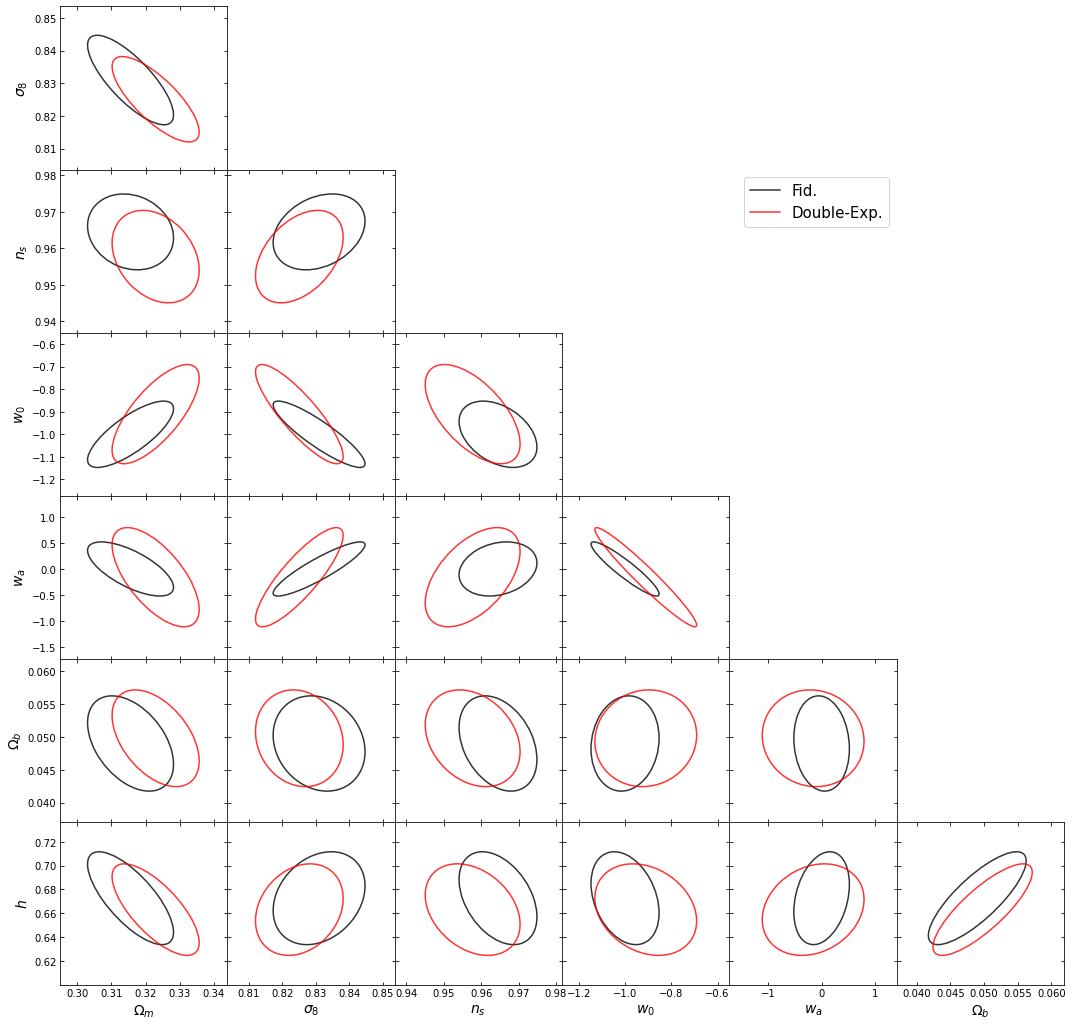

In [44]:
plot_n_fish([nonlinear, nonlinear_shift4], ['black','red' ], ['Fid.', 'Double-Exp.'])







In [ ]:
plot_n_fish([nonlinear,nonlinear_shift1,nonlinear_shift2, nonlinear_shift3], ['black', 'blue','green', 'red'], ['Fid.', 'Exp. + Const.', 'Exp.', 'Power'])







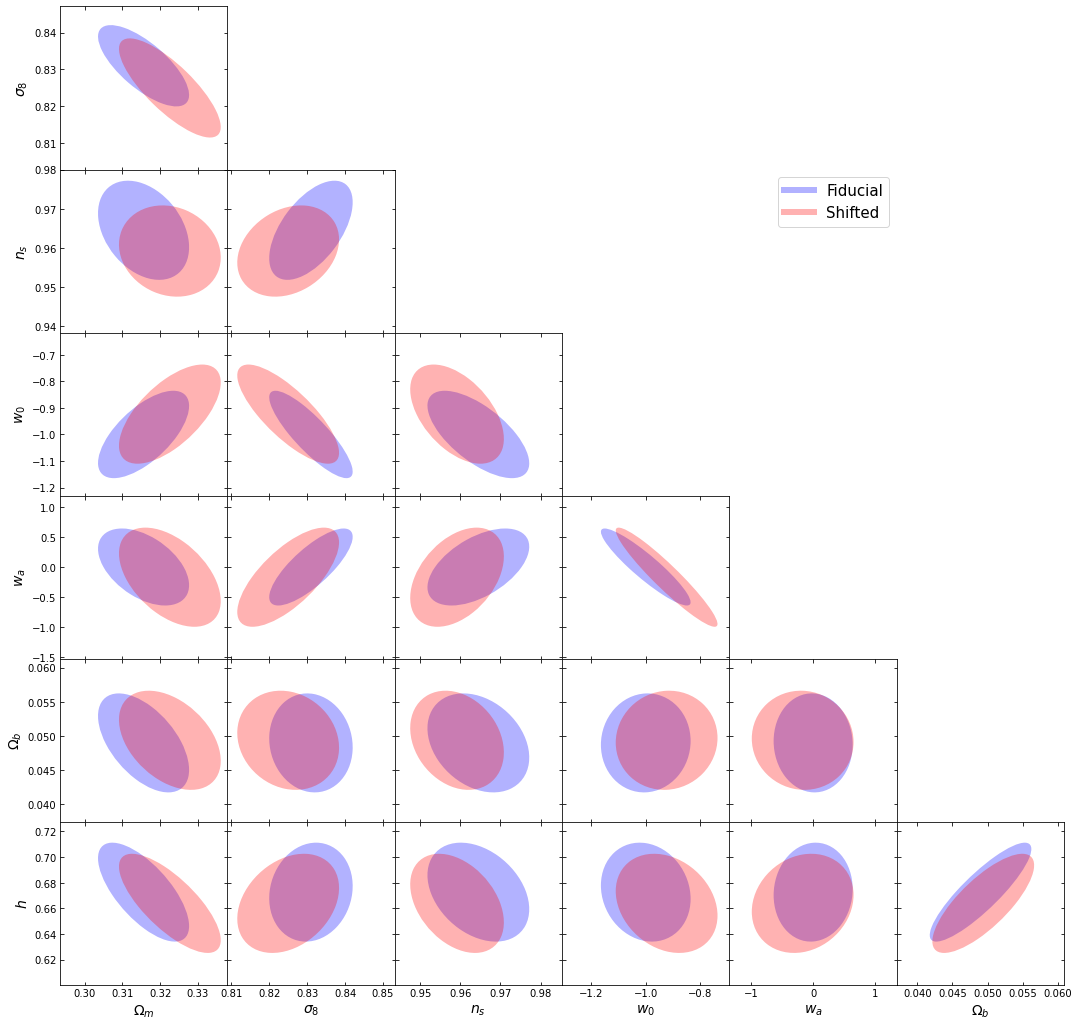

In [218]:
plot_two_fish(nonlinear,nonlinear_shift)